# Imports

In [2]:
import requests
import csv
import json
import pandas as pd
from bs4 import BeautifulSoup, Comment
import matplotlib.pyplot as plt
import time
import re
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import seaborn as sns
import warnings

# Data Scraping


In [ ]:
def get_draft_picks(year, draft_dict):
  players_without_stats = ['Jimmy Garoppolo', 'Jaquiski Tartt', 'Ali Marpet', 'Adam Shaheen', 'Tanoh Kpassagnon', 'Shaquille Leonard', 'Dallas Goedert', 'P.J. Hall', 'Tytus Howard', 'Nasir Adderley', 'Kyle Dugger', 'Jeremy Chinn']
  url = f"https://www.pro-football-reference.com/years/{year}/draft.htm"
  url2 = f'https://en.wikipedia.org/wiki/{year}_NFL_draft'
  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')
  response2 = requests.get(url2)
  soup2 = BeautifulSoup(response2.content, 'html.parser')
  players = soup.find_all("td", {"data-stat": "player"})
  ages = soup.find_all("td", {"data-stat": "age"})
  first_team_aps = soup.find_all("td", {"data-stat": "all_pros_first_team"})
  pro_bowls = soup.find_all("td", {"data-stat": "pro_bowls"})
  career_av = soup.find_all("td", {"data-stat": "career_av"})
  years_as_primary_starter = soup.find_all("td", {"data-stat": "years_as_primary_starter"})
  position = soup.find_all("td", {"data-stat": "pos"})
  college_links = soup.findAll('a', href=True, string='College Stats')
  draft_picks = []
  college_link_counter = 0
  for i in range(64):
    player_dict = {}
    last_name, first_name, = players[i]["csk"].split(',')
    #print(players[i].findChildren())
    full_name = (players[i].findChildren('a')[0].text).replace('.', '. ', 1).strip(' ')
    link_name = (first_name + '-' + last_name).lower()
    #print(full_name)
    try:
      wiki_link_name = soup2.find('a', string=full_name, href=True)['href'].strip('/wiki')
    except:
      wiki_link_name = ''
    #print(wiki_link_name)
    wiki_link = f'https://en.wikipedia.org/wiki/{wiki_link_name}'
    player_dict.update({'Age' : ages[i].text})
    player_dict.update({'All-Pros' : first_team_aps[i].text})
    player_dict.update({'Pro Bowls' : pro_bowls[i].text})
    player_dict.update({'Career AV' : career_av[i].text})
    player_dict.update({'Years as Starter (NFL)' : years_as_primary_starter[i].text})
    player_dict.update({'Position' : position[i].text})
    player_dict.update({'Wikipedia Link' : wiki_link})
    draft_dict[full_name] = player_dict

    if full_name not in players_without_stats:
      print(full_name, college_links[college_link_counter]['href'])
      college_stats_link = college_links[college_link_counter]['href']
      player_dict.update({'College Stats Link' : college_stats_link})
      get_college_stats(college_stats_link, draft_pick_data, full_name, position[i].text)
    else:
      print(full_name)
      college_link_counter -= 1
    time.sleep(5)
    college_link_counter += 1

draft_pick_data = {}

for year in range(2014, 2021):
  get_draft_picks(year, draft_pick_data)

Jadeveon Clowney http://www.sports-reference.com/cfb/players/jadeveon-clowney-1.html
Greg Robinson http://www.sports-reference.com/cfb/players/greg-robinson-3.html
Blake Bortles http://www.sports-reference.com/cfb/players/blake-bortles-1.html
Sammy Watkins http://www.sports-reference.com/cfb/players/sammy-watkins-1.html
Khalil Mack http://www.sports-reference.com/cfb/players/khalil-mack-1.html
Jake Matthews http://www.sports-reference.com/cfb/players/jake-matthews-2.html
Mike Evans http://www.sports-reference.com/cfb/players/mike-evans-4.html
Justin Gilbert http://www.sports-reference.com/cfb/players/justin-gilbert-1.html
Anthony Barr http://www.sports-reference.com/cfb/players/anthony-barr-1.html
Eric Ebron http://www.sports-reference.com/cfb/players/eric-ebron-1.html
Taylor Lewan http://www.sports-reference.com/cfb/players/taylor-lewan-1.html
Odell Beckham Jr. http://www.sports-reference.com/cfb/players/odell-beckham-jr-1.html
Aaron Donald http://www.sports-reference.com/cfb/players/

In [ ]:
print(draft_pick_data['DeMarcus Walker'])

{'Age': '22', 'All-Pros': '0', 'Pro Bowls': '0', 'Career AV': '17', 'Years as Starter (NFL)': '0', 'Position': 'DE', 'Wikipedia Link': 'https://en.wikipedia.org/wiki/DeMarcus_Walker', 'College Stats Link': 'http://www.sports-reference.com/cfb/players/demarcus-walker-1.html', 'Solo Tackles_C': '109', 'Assisted Tackles_C': '73', 'Total Tackles_C': '182', 'Tackles for Loss_C': '45.0', 'Sacks_C': '28.5', 'Defensive Interceptions_C': '1', 'Passes Defended_C': '7', 'Fumble Recoveries_C': '2', 'Forced Fumbles_C': '8'}


In [ ]:
for player in draft_pick_data:
  player_name = player.replace(' ', '_')
  url = draft_pick_data[player]['Wikipedia Link']
  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')
  tables = soup.find_all('td', {'class':'infobox-full-data'})
  nattys = 0
  for table in tables:
    for accolade in table.text.split('\n'):
      if 'national champion ' in accolade.lower():
        if accolade.lower()[0] == '2':
          nattys += 1
        nattys += 1
  draft_pick_data[player].update({'National Championships' : nattys}


In [ ]:
fields = ['Player Name', 'Age (When Drafted)', 'All-Pros', 'Pro Bowls', 'Career AV', 'Years as Starter (NFL)', 'National Championships', 'College Stats Link', 'Wikipedia Link']

with open('draft_picks.json', 'w') as jsonfile:
    json.dump(draft_pick_data, jsonfile, indent=4)

#with open('draft_picks.csv', 'w') as csvfile:
  #csv_writer = csv.writer(csvfile)
  #csv_writer.writerow(fields)
  #for player in draft_pick_data:
    #temp_player = {'Name':player, 'Age (When Drafted)':draft_pick_data[player]['Age'], 'All-Pros':draft_pick_data[player]['All-Pros'], 'Pro Bowls':draft_pick_data[player]['Pro Bowls'], 'Career AV':draft_pick_data[player]['Career AV'], 'Years as Starter (NFL)':draft_pick_data[player]['Years as Starter (NFL)'], 'National Championships':draft_pick_data[player]['National Championships'], 'College Stats Link':draft_pick_data[player]['College Stats Link'], 'Wikipedia Link':draft_pick_data[player]['Wikipedia Link'], 'Completions_C':draft_pick_data[player]['Completions']}
    #csv_writer.writerow(temp_player.values())
#csvfile.close()

In [ ]:
def get_college_stats(url, draft_pick_data, player, position):
  if position == 'QB':
    url = f'{url}#all_passing'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')


    table = soup.find('tfoot').find_all('td')
    draft_pick_data[player].update({'Completions_C' : (table[5].text)})
    draft_pick_data[player].update({'Passing Attempts_C' : (table[6].text)})
    draft_pick_data[player].update({'Completion Pct_C' : (table[7].text)})
    draft_pick_data[player].update({'Passing Yards_C' : (table[8].text)})
    draft_pick_data[player].update({'Passing Yards per Attempt_C' : (table[9].text)})
    draft_pick_data[player].update({'Adj Passing Yards per Attempt_C' : (table[10].text)})
    draft_pick_data[player].update({'Passing Touchdowns_C' : (table[11].text)})
    draft_pick_data[player].update({'Interceptions_C' : (table[12].text)})
    draft_pick_data[player].update({'Passer Rating_C' : (table[13].text)})

  elif position == 'RB' or position == 'WR' or position == 'TE':
    url = f'{url}#all_rushing'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    table = soup.find('tfoot').find_all('td')
    draft_pick_data[player].update({'Rushing Attempts_C' : (table[9].text)})
    draft_pick_data[player].update({'Rushing Yards_C' : (table[10].text)})
    draft_pick_data[player].update({'Rushing Yards per Attempt_C' : (table[11].text)})
    draft_pick_data[player].update({'Rushing TDs_C' : (table[12].text)})
    draft_pick_data[player].update({'Receptions_C' : (table[5].text)})
    draft_pick_data[player].update({'Receiving Yards_C' : (table[6].text)})
    draft_pick_data[player].update({'Receiving Yards per Attempt_C' : (table[7].text)})
    draft_pick_data[player].update({'Receiving Touchdowns_C' : (table[8].text)})

  elif position == 'DB' or position == 'LB' or position == 'DT' or position == 'DE' or position == 'DT':
    url = f'{url}#all_defense'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    table = soup.find('tfoot').find_all('td')
    draft_pick_data[player].update({'Solo Tackles_C' : (table[5].text)})
    draft_pick_data[player].update({'Assisted Tackles_C' : (table[6].text)})
    draft_pick_data[player].update({'Total Tackles_C' : (table[7].text)})
    draft_pick_data[player].update({'Tackles for Loss_C' : (table[8].text)})
    draft_pick_data[player].update({'Sacks_C' : (table[9].text)})
    draft_pick_data[player].update({'Defensive Interceptions_C' : (table[10].text)})
    draft_pick_data[player].update({'Passes Defended_C' : (table[14].text)})
    draft_pick_data[player].update({'Fumble Recoveries_C' : (table[15].text)})
    draft_pick_data[player].update({'Forced Fumbles_C' : (table[18].text)})



In [ ]:
df = pd.read_json('draft_picks.json')
df = df.fillna(0)
df = df.T

df.to_csv('draft_picks.csv')


In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
df = pd.read_csv('draft_picks_2014_2020.csv')

nfl_links = []

df.rename(columns = {'Unnamed: 0':'Player'}, inplace = True)

for player in range(len(df['Player'])):
  if df['Player'][player].find('. K') != -1:
    df['Player'][player] = df['Player'][player].replace(". K", ".K")
  elif df['Player'][player].find('. J') != -1:
    df['Player'][player] = df['Player'][player].replace(". J", ".J")


counter = 0
for i in range(2014, 2021):
  url = f"https://www.pro-football-reference.com/years/{i}/draft.htm"
  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')
  for j in range(64):
    #print(j, counter, df['Player'][counter])
    if counter == 447:
      break
    if df['Player'][counter] == 'Joe Burrow':
      nfl_link_temp = 'BurrJo01.htm'
    else:
      nfl_link_temp = soup.find('a', href=True, string=df['Player'][counter])['href']
    #print(counter, df['Player'][counter], nfl_link_temp)
    counter += 1
    nfl_links.append('https://www.pro-football-reference.com/' + nfl_link_temp)

print(nfl_links)


['https://www.pro-football-reference.com//players/C/ClowJa00.htm', 'https://www.pro-football-reference.com//players/R/RobiGr01.htm', 'https://www.pro-football-reference.com//players/B/BortBl00.htm', 'https://www.pro-football-reference.com//players/W/WatkSa00.htm', 'https://www.pro-football-reference.com//players/M/MackKh00.htm', 'https://www.pro-football-reference.com//players/M/MattJa00.htm', 'https://www.pro-football-reference.com//players/E/EvanMi00.htm', 'https://www.pro-football-reference.com//players/G/GilbJu00.htm', 'https://www.pro-football-reference.com//players/B/BarrAn00.htm', 'https://www.pro-football-reference.com//players/E/EbroEr00.htm', 'https://www.pro-football-reference.com//players/L/LewaTa00.htm', 'https://www.pro-football-reference.com//players/B/BeckOd00.htm', 'https://www.pro-football-reference.com//players/D/DonaAa00.htm', 'https://www.pro-football-reference.com//players/F/FullKy00.htm', 'https://www.pro-football-reference.com//players/S/ShazRy00.htm', 'https://

In [ ]:
#df.insert(8, 'NFL Stats Link', nfl_links)
df.to_csv('draft_picks.csv')

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
df = pd.read_csv('Players.csv')

for idx in df.index:
  position = df.loc[idx]['Position']
  url = df.loc[idx]['College Stats Link']
  '''
  if position == 'QB':
    print(df.loc[idx]['Player'])
    if df.loc[idx]['Player'] == 'Christian Hackenberg':
      continue
    if df.loc[idx]['Player'] == 'Joe Burrow':
      url = 'https://www.pro-football-reference.com/players/B/BurrJo01.htm'
    url = f'{url}#all_passing'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('tfoot').find_all('td')
    df.at[idx, 'ompletions_NFL'] = int(table[6].text) if table[6].text != '' else 0
    df.at[idx, 'Passing Attempts_NFL'] = int(table[7].text) if table[7].text != '' else 0
    df.at[idx, 'ompletion Pct_NFL'] = float(table[8].text) if table[8].text != '' else 0
    df.at[idx, 'Passing Yards_NFL'] = int(table[9].text) if table[9].text != '' else 0
    df.at[idx, 'Passing Yards per Attempt_NFL'] = float(table[17].text) if table[17].text != '' else 0
    df.at[idx, 'Adj Passing Yards per Attempt_NFL'] = float(table[18].text) if table[18].text != '' else 0
    df.at[idx, 'Passing Touchdowns_NFL'] = int(table[10].text) if table[10].text != '' else 0
    df.at[idx, 'Interceptions_NFL'] = int(table[12].text) if table[12].text != '' else 0
    df.at[idx, 'Passer Rating_NFL'] = float(table[21].text) if table[21].text != '' else 0
  time.sleep(.5)
  url = df.loc[idx]['NFL Stats Link']
  '''

  if df.loc[idx]['Player'] != 'Jeremy Chinn' and df.loc[idx]['Player'] != 'Kyle Dugger' and df.loc[idx]['Player'] != 'Jaquiski Tartt' and df.loc[idx]['Player'] != 'Nasir Adderley'and (position == 'S' or df.loc[idx]['Player'] == 'Cyrus Jones' or df.loc[idx]['Player'] == 'Isaiah Oliver' or df.loc[idx]['Player'] == 'Carlton Davis'):
    print(df.loc[idx]['Player'])
    url = f'https://web.archive.org/web/2/{url}#all_defense'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    time.sleep(15)
    try:
      table = soup.find('tfoot').find_all('td')
        #print(table[17].text)
        #try:
      df.at[idx, 'Solo Tackles_C'] = int(table[5].text) if table[5].text != '' else 0
      df.at[idx, 'Assisted Tackles_C'] = int(table[6].text) if table[6].text != '' else 0
      df.at[idx, 'Total Tackles_C'] = int(table[7].text) if table[7].text != '' else 0
      df.at[idx, 'Tackles for Loss_C'] = float(table[8].text) if table[8].text != '' else 0
      df.at[idx, 'Sacks_C'] = float(table[9].text) if table[9].text != '' else 0
      df.at[idx, 'Defensive Interceptions_C'] = int(table[10].text) if table[10].text != '' else 0
      df.at[idx, 'Passes Defended_C'] = int(table[14].text) if table[14].text != '' else 0
      df.at[idx, 'Fumble Recoveries_C'] = int(table[15].text) if table[15].text != '' else 0
      df.at[idx, 'Forced Fumbles_C'] = int(table[18].text) if table[18].text != '' else 0
        #except:
          #print('ERROR - data')
          #continue
    except:
      print('ERROR - table')
      continue
  url = df.loc[idx]['College Stats Link']

  '''
  if position == 'RB':
    print(df.loc[idx]['Player'])
    url = f'{url}#all_rushing_and_receiving'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('tfoot').find_all('td')
    df.at[idx, 'Rushing Attempts_NFL'] = int(table[5].text) if table[5].text != '' else 0
    df.at[idx, 'Rushing Yards_NFL'] = int(table[6].text) if table[6].text != '' else 0
    df.at[idx, 'Rushing Yards per Attempt_NFL'] = float(table[11].text) if table[11].text != '' else 0
    df.at[idx, 'Rushing TDs_NFL'] = int(table[7].text) if table[7].text != '' else 0
    df.at[idx, 'Receptions_NFL'] = int(table[15].text) if table[15].text != '' else 0
    df.at[idx, 'Receiving Yards_NFL'] = int(table[16].text) if table[16].text != '' else 0
    df.at[idx, 'Receiving Yards per Attempt_NFL'] = float(table[17].text) if table[17].text != '' else 0
    df.at[idx, 'Receiving Touchdowns_NFL'] = int(table[18].text) if table[18].text != '' else 0
  time.sleep(.5)
  '''
  '''
  if position == 'WR' or position == 'TE':
    print(df.loc[idx]['Player'])
    url = f'{url}#all_rushing_and_receiving'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('tfoot').find_all('td')
    df.at[idx, 'Rushing Attempts_NFL'] = int(table[17].text) if table[17].text != '' else 0
    df.at[idx, 'Rushing Yards_NFL'] = int(table[18].text) if table[18].text != '' else 0
    df.at[idx, 'Rushing Yards per Attempt_NFL'] = float(table[23].text) if table[23].text != '' else 0
    df.at[idx, 'Rushing TDs_NFL'] = int(table[19].text) if table[19].text != '' else 0
    df.at[idx, 'Receptions_NFL'] = int(table[6].text) if table[6].text != '' else 0
    df.at[idx, 'Receiving Yards_NFL'] = int(table[7].text) if table[7].text != '' else 0
    df.at[idx, 'Receiving Yards per Attempt_NFL'] = float(table[8].text) if table[8].text != '' else 0
    df.at[idx, 'Receiving Touchdowns_NFL'] = int(table[9].text) if table[9].text != '' else 0
  time.sleep(.5)
  '''
  '''
  if position == 'QB':
    print(df.loc[idx]['Player'])
    if df.loc[idx]['Player'] == 'Christian Hackenberg':
      continue
    #url = f'{url}#all_passing'
    #url = f'{url}#all_rushing_and_receiving'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find("table", { "id" : "rushing_and_receiving" }).find('tfoot').find_all('td')
    df.at[idx, 'Rushing Attempts_NFL'] = int(table[5].text) if table[5].text != '' else 0
    df.at[idx, 'Rushing Yards_NFL'] = int(table[6].text) if table[6].text != '' else 0
    df.at[idx, 'Rushing Yards per Attempt_NFL'] = float(table[11].text) if table[11].text != '' else 0
    df.at[idx, 'Rushing TDs_NFL'] = int(table[7].text) if table[7].text != '' else 0
    df.at[idx, 'Receptions_NFL'] = int(table[15].text) if table[15].text != '' else 0
    df.at[idx, 'Receiving Yards_NFL'] = int(table[16].text) if table[16].text != '' else 0
    df.at[idx, 'Receiving Yards per Attempt_NFL'] = float(table[17].text) if table[17].text != '' else 0
    df.at[idx, 'Receiving Touchdowns_NFL'] = int(table[18].text) if table[18].text != '' else 0
  time.sleep(.5)
  '''
df.to_csv('Players_Updated.csv')

Calvin Pryor
Ha Ha Clinton-Dix
Deone Bucannon
Jimmie Ward
Damarious Randall
Landon Collins
Jordan Richards
Karl Joseph
Keanu Neal
Su'a Cravens
T.J. Green
Cyrus Jones
Vonn Bell
Kevin Byard
Jamal Adams
Malik Hooker
Jabrill Peppers
Budda Baker
Marcus Maye
Marcus Williams
Justin Evans
Obi Melifonwu
Josh Jones
Minkah Fitzpatrick
Derwin James
Terrell Edmunds
Jessie Bates III
Isaiah Oliver
Carlton Davis
Darnell Savage Jr.
Johnathan Abram
Marquise Blair
Taylor Rapp
Juan Thornhill
Xavier McKinney
Grant Delpit
Antoine Winfield Jr.
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
ERROR - table
nan
E

In [ ]:
url = 'https://web.archive.org/web/2/https://www.sports-reference.com/cfb/players/vonn-bell-2.html#all_defense'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('tfoot').find_all('td')
print(table[7])

<td class="right" data-stat="tackles_total">175</td>


In [ ]:
df = pd.read_csv('draft_picks.csv')
columns = df.columns
for i in range(9, 35):
  column = df.columns[i]
  new_column = column.strip('C') + 'NFL'
  df[new_column] = pd.Series(dtype=df[column].dtype)

In [ ]:
df = pd.read_csv('draft_picks.csv')
df = df.fillna(0)
df.to_csv('draft_picks.csv')

In [ ]:
df = pd.read_csv('draft_picks.csv')

for i, player in df.iterrows():
  if player['Position'] == 'QB' and player['College Stats Link'] != '0':
    c_url = player['College Stats Link']
    url = f'{c_url}#all_rushing'
    print(player['Player'], url)

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('div',{'id':'rushing'}).find('tfoot').find_all('td')

    df.at[i,'Rushing Attempts_C'] = int(table[9].text)
    df.at[i,'Rushing Yards_C'] = int(table[10].text)
    df.at[i,'Rushing Yards per Attempt_C'] = float(table[11].text)
    df.at[i,'Rushing TDs_C'] = int(table[12].text)
    df.at[i,'Receptions_C'] = int(table[5].text)
    df.at[i,'Receiving Yards_C'] = int(table[6].text)
    df.at[i,'Receiving Yards per Attempt_C'] = float(table[7].text)
    df.at[i,'Receiving Touchdowns_C'] = int(table[8].text)

    time.sleep(5)

df.to_csv('draft_picks.csv')

Blake Bortles http://www.sports-reference.com/cfb/players/blake-bortles-1.html#all_rushing


AttributeError: 'NoneType' object has no attribute 'find_all'

In [ ]:
df = pd.read_csv('draft_picks2.csv')

df.insert(10, 'Conference', '')
df.insert(10, 'Conference_Group', '')

df.to_csv('draft_picks.csv')

In [ ]:
conferences = {'P5':['SEC', 'Big Ten','Big 12', 'Pac-12', 'ACC'], 'G5':['American', 'CUSA', 'MAC', 'MWC', 'Sun Belt']}

df = pd.read_csv('draft_picks.csv')

df = df.fillna('')

for i, player in df.iterrows():
  print(player['Player'], player['Conference'])
  if player['College Stats Link'] != '0':
    url = player['College Stats Link']
    print(player['Player'], player['Conference'])
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    try:
      table = soup.find('tbody').find_all('tr')
    except:
      print('UH OH')
      continue

    df.at[i,'Conference'] = table[len(table) - 1].find('td', {'data-stat':'conf_abbr'}).text

    time.sleep(5)

df.to_csv('draft_picks.csv')

Jadeveon Clowney SEC
Greg Robinson SEC
Blake Bortles American
Sammy Watkins ACC
Khalil Mack MAC
Jake Matthews Pac-12
Mike Evans SEC
Justin Gilbert Big 12
Anthony Barr Pac-12
Eric Ebron ACC
Taylor Lewan Big Ten
Odell Beckham Jr. SEC
Aaron Donald ACC
Kyle Fuller ACC
Ryan Shazier Big Ten
Zack Martin Ind
C.J. Mosley SEC
Calvin Pryor American
Ja'Wuan James SEC
Brandin Cooks Pac-12
Ha Ha Clinton-Dix SEC
Johnny Manziel SEC
Dee Ford SEC
Darqueze Dennard Big Ten
Jason Verrett Big 12
Marcus Smith American
Deone Bucannon Pac-12
Kelvin Benjamin ACC
Dominique Easley SEC
Jimmie Ward MAC
Bradley Roby Big Ten
Teddy Bridgewater American
Xavier Su'a-Filo 
Xavier Su'a-Filo 
UH OH
DeMarcus Lawrence MWC
Joel Bitonio MWC
Derek Carr MWC
Ra'Shede Hageman Big Ten
Austin Seferian-Jenkins Pac-12
Marqise Lee Pac-12
Kyle Van Noy Ind
Lamarcus Joyner ACC
Jordan Matthews SEC
Weston Richburg MWC
Cyrus Kouandjio 
Cyrus Kouandjio 
UH OH
Paul Richardson Pac-12
Stephon Tuitt Ind
Trent Murphy Pac-12
Timmy Jernigan ACC
Jace

In [ ]:
df = pd.read_csv('draft_picks.csv')

df.insert(21, 'College Accolades', 0)

df.to_csv('draft_picks.csv')

In [ ]:
df = pd.read_csv('draft_picks.csv')
for i, player in df.iterrows():
  print(player['Player'])
  url = player['Wikipedia Link']
  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')
  tables = soup.find_all('td', {'class':'infobox-full-data'})
  draft_year = player['Draft Year']
  accolade_counter = 0
  for table in tables:
    contents = table.find_all('li')
    for line in contents:
      accolade = line.text.split('(')
      if len(accolade) > 1:
        year = '(' + accolade[1:][0]
        year = re.findall('\(.*?\)', year)[0].strip('(').strip(')').split(',')[0].split('–')[0].split('−')[0].split('-')[0]
        year = re.sub(r"[\[\-].*?[\n\]]", "", year)
        if ord(year[0]) >= 50 and ord(year[0]) <= 57 and int(year) < draft_year  and 'national champion' not in accolade[0]:
          multiplier = int(accolade[0][0]) if ord(accolade[0][0]) >= 50 and ord(accolade[0][0]) <= 57 else 1
          accolade_counter += multiplier
  df.at[i, 'College Accolades'] = accolade_counter

Jadeveon Clowney
Greg Robinson
Blake Bortles
Sammy Watkins
Khalil Mack
Jake Matthews
Mike Evans
Justin Gilbert
Anthony Barr
Eric Ebron
Taylor Lewan
Odell Beckham Jr.
Aaron Donald
Kyle Fuller
Ryan Shazier
Zack Martin
C.J. Mosley
Calvin Pryor
Ja'Wuan James
Brandin Cooks
Ha Ha Clinton-Dix
Johnny Manziel
Dee Ford
Darqueze Dennard
Jason Verrett
Marcus Smith
Deone Bucannon
Kelvin Benjamin
Dominique Easley
Jimmie Ward
Bradley Roby
Teddy Bridgewater
Xavier Su'a-Filo
DeMarcus Lawrence
Joel Bitonio
Derek Carr
Ra'Shede Hageman
Austin Seferian-Jenkins
Marqise Lee
Kyle Van Noy
Lamarcus Joyner
Jordan Matthews
Weston Richburg
Cyrus Kouandjio
Paul Richardson
Stephon Tuitt
Trent Murphy
Timmy Jernigan
Jace Amaro
Jeremiah Attaochu
Ego Ferguson
Troy Niklas
Davante Adams
Bishop Sankey
Jeremy Hill
Cody Latimer
Carlos Hyde
Stanley Jean-Baptiste
Jack Mewhort
Kony Ealy
Allen Robinson
Jimmy Garoppolo
Jarvis Landry
Justin Britt
Jameis Winston
Marcus Mariota
Dante Fowler
Amari Cooper
Brandon Scherff
Leonard Willi

In [ ]:
url = 'https://en.wikipedia.org/wiki/Shaquille_Leonard'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
draft_year = 2021
tables = soup.find_all('td', {'class':'infobox-full-data'})
accolade_counter = 0
for table in tables:
  contents = table.find_all('li')
  for line in contents:
    accolade = line.text.split('(')
    #print(accolade)
    if len(accolade) > 1:
      year = '(' + accolade[1:][0]
      year = re.findall('\(.*?\)', year)[0].strip('(').strip(')').split(',')[0].split('–')[0].split('−')[0].split('-')[0]
      year = re.sub(r"[\[\-].*?[\n\]]", "", year)
      print(year)
      #if int(year) < draft_year and 'national champion' not in accolade[0]:
        #multiplier = int(accolade[0][0]) if ord(accolade[0][0]) >= 50 and ord(accolade[0][0]) <= 57 else 1
        #accolade_counter += multiplier

print(accolade_counter)

2018
2023
2018
2018
2019
2019
2021
2018
2018
2018
2016
2015
0


In [ ]:
players = pd.read_csv('Players (Kicker and OLine Removed).csv')
ras = pd.read_csv('RAS_Scores.csv')

players.insert(13, 'Relative Athletic Score', 0)


Index            Player  Draft Year Position  Age  All-Pros  Pro Bowls  \
0        0  Jadeveon Clowney        2014       DE   21         0          3   
1        1     Blake Bortles        2014       QB   22         0          0   
2        2     Sammy Watkins        2014       WR   21         0          0   
3        3       Khalil Mack        2014       LB   23         3          8   
4        4        Mike Evans        2014       WR   21         0          5   
..     ...               ...         ...      ...  ...       ...        ...   
367    367         Josh Uche        2020       LB   21         0          0   
368    368   Kristian Fulton        2020       CB   22         0          0   
369    369         AJ Dillon        2020       RB   22         0          0   
370    370    Willie Gay Jr.        2020       LB   22         0          0   
371    371      Jeremy Chinn        2020        S   22         0          0   

     NFL Success  Career AV  Years as Starter (NFL)  ...  Rushing Yards_NFL  \
0              1         59                       8  ...                  0   
1              0         44                       5  ...               1766   
2              0         43                       6  ...                 76   
3              1         95                       8  ...                  0   
4              1         73                       9  ...                 10   
..           ...        ...                     ...  ...                ...   
367            0          8                       0  ...                  0   
368            0         13                       2  ...                  0   
369            0         23                       0  ...               2428   
370            0         22                       3  ...                  0   
371            0         33                       3  ...                  0   

    Rushing Yards per Attempt_NFL  Rushing TDs_NFL  Receptions_NFL  \
0                             0.0                0               0   
1                             6.2                8               1   
2                             6.9                0             364   
3                             0.0                0               0   
4                            10.0                0             762   
..                            ...              ...             ...   
367                           0.0                0               0   
368                           0.0                0               0   
369                           4.1               16              86   
370                           0.0                0               0   
371                           0.0                0               0   

     Receiving Yards_NFL  Receiving Yards per Attempt_NFL  \
0                      0                              0.0   
1                     20                             20.0   
2                   5384                             14.8   
3                      0                              0.0   
4                  11680                             15.3   
..                   ...                              ...   
367                    0                              0.0   
368                    0                              0.0   
369                  763                              8.9   
370                    0                              0.0   
371                    0                              0.0   

     Receiving Touchdowns_NFL  \
0                           0   
1                           1   
2                          34   
3                           0   
4                          94   
..                        ...   
367                         0   
368                         0   
369                         2   
370                         0   
371                         0   

                                        Wikipedia Link  \
0       https://en.wikipedia.org/wiki/Jadeveon_Clowney   
1          https://e

In [ ]:
print(float(ras[ras['Name'] == 'Brandin Cooks']['RAS']))

9.14


<ipython-input-31-b0fbc42b4e46>:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(float(ras[ras['Name'] == 'Brandin Cooks']['RAS']))


In [ ]:
for i, player in players.iterrows():
  name = player['Player'].split(' ')
  first_name, last_name = name[0], name[1]
  name = first_name + ' ' + last_name
  #print(name, end = ' ')
  try:
    ras_score = float(ras[ras['Name'] == name]['RAS'])
    players.at[i, 'Relative Athletic Score'] = ras_score
    #print(ras_score)
  except:
    #print()
    continue

<ipython-input-28-99fcf92b8283>:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ras_score = float(ras[ras['Name'] == name]['RAS'])


In [ ]:
players.to_csv('players.csv')

# Analysis

##Modified URMC

Methodology: https://assets.pubpub.org/4ba6kxxp/51653583818989.pdf

In [ ]:
def modified_urmc(corr_dict, features):
  weights = [0 for i in range(len(features))]

  for i in range(len(features)):
    for j in range(i + 1, len(features)):
      if corr_dict[f'{i}:{j}'] >= 0:
        if weights[i] >= 0 and weights[j] >= 0:
          weights[i] = weights[i] + corr_dict[f'{i}:{j}']
          weights[j] = weights[j] + corr_dict[f'{i}:{j}']
        elif weights[i] < 0 and weights[j] < 0:
          weights[i] = weights[i] - corr_dict[f'{i}:{j}']
          weights[j] = weights[j] - corr_dict[f'{i}:{j}']
        elif weights[i] >= 0 and weights[j] < 0:
          weights[i] = weights[i] - corr_dict[f'{i}:{j}']
          weights[j] = weights[j] + corr_dict[f'{i}:{j}']
        else:
          weights[i] = weights[i] + corr_dict[f'{i}:{j}']
          weights[j] = weights[j] - corr_dict[f'{i}:{j}']
      else:
        if weights[i] >= 0 and weights[j] >= 0:
          if weights[i] < weights[j]:
            weights[i] = weights[i] + corr_dict[f'{i}:{j}']
            weights[j] = weights[j] - corr_dict[f'{i}:{j}']
          else:
            weights[i] = weights[i] - corr_dict[f'{i}:{j}']
            weights[j] = weights[j] + corr_dict[f'{i}:{j}']
        elif weights[i] < 0 and weights[j] < 0:
          if weights[i] < weights[j]:
            weights[i] = weights[i] + corr_dict[f'{i}:{j}']
            weights[j] = weights[j] - corr_dict[f'{i}:{j}']
          else:
            weights[i] = weights[i] - corr_dict[f'{i}:{j}']
            weights[j] = weights[j] + corr_dict[f'{i}:{j}']
        elif weights[i] >= 0 and weights[j] < 0:
          weights[i] = weights[i] - corr_dict[f'{i}:{j}']
          weights[j] = weights[j] + corr_dict[f'{i}:{j}']
        else:
          weights[i] = weights[i] + corr_dict[f'{i}:{j}']
          weights[j] = weights[j] - corr_dict[f'{i}:{j}']

  return weights

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def calc_rank_score(normalized_data, weights, features):
  rank_scores = {}

  for i, player in normalized_data.iterrows():
    rank_score = 0
    for j in range(len(features)):
      rank_score += weights[j] * normalized_data.at[i, features[j]]

    rank_scores.update({i:rank_score})

  return  dict(sorted(rank_scores.items(), key=lambda x:x[1], reverse=True))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def label_classes()

In [ ]:
data = pd.read_csv('Players.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def mod_urmc_wrapper(position_data, features, features_wo_success, position):
  #Normalize variables
  position_data_normalized = position_data

  for feature in features_wo_success:
    col_min = min(position_data[feature])
    col_max = max(position_data[feature])
    for i, observation in position_data.iterrows():
      new_obs = 1 + (9 * ((observation[feature] - col_min) / (col_max - col_min)))
      position_data_normalized.at[i, feature] = new_obs

  #Display correlations between each normalized variable and NFL Success V2
  position_data_normalized_corr = position_data_normalized.drop(['NFL Success V2'], axis=1).corr()
  #display(position_data_normalized_corr.style.background_gradient())

  #Create a dictionary of all correlation coefficients and their corresponding row and colun
  position_data_normalized_corr_dict = {}

  for i in range(len(features_wo_success)):
    for j in range(len(features_wo_success)):
      corr = position_data_normalized_corr.at[features_wo_success[i], features_wo_success[j]]
      if corr not in position_data_normalized_corr_dict.values() and corr != 1:
        position_data_normalized_corr_dict.update({f'{i}:{j}':corr})

  #Sort the dictionary in descending order by correlation coefficient
  position_data_normalized_corr_dict = dict(sorted(position_data_normalized_corr_dict.items(), key=lambda x:x[1], reverse=True))

  #Calculate each correlation coefficient's weight and store in a list
  weights = modified_urmc(position_data_normalized_corr_dict, features_wo_success)

  #Calculate the rank score of each player
  rank_scores = calc_rank_score(position_data_normalized, weights, features_wo_success)

  #Create a dataframe with all players, their rank score, and their success
  all_players = pd.DataFrame()

  for key in rank_scores.keys():
    temp_df = pd.DataFrame([{'Name': data.at[key, 'Player'], 'Rank Score': rank_scores[key], 'NFL Success': data.at[key, 'NFL Success V2'], 'Career AV': data.at[key, 'Career AV']}])
    all_players = pd.concat([all_players,temp_df])

  #Create a dataframe with only successful players
  successful_players = all_players[all_players['NFL Success'] == 1]

  #Create histograms showing the distribution of rank scores among successful and unsuccessful players
  sns.histplot(all_players, x='Rank Score', hue='NFL Success', multiple='dodge', shrink=.75, bins=10)
  plt.show()

  sns.scatterplot(all_players, x='Rank Score', y='Career AV', hue='NFL Success').set_title(f'Rank Score vs Career AV {position}', fontsize=9)
  plt.show()

  #display(all_players.sort_values(by=['Rank Score']))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


QUARTERBACKS:


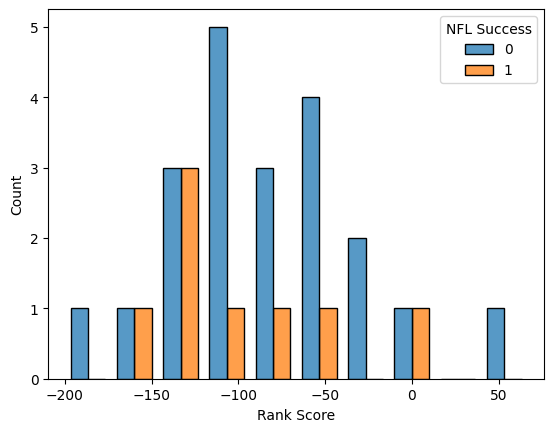

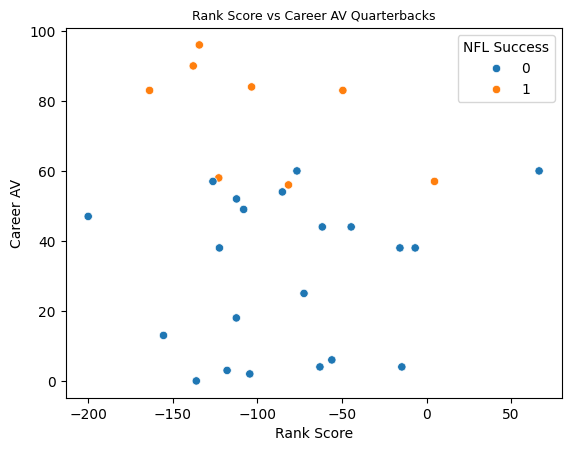

RUNNINGBACKS:


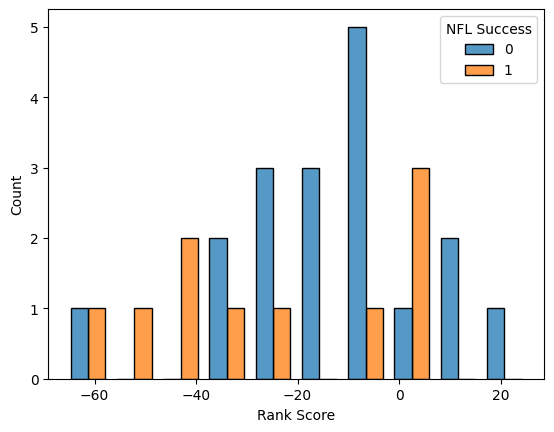

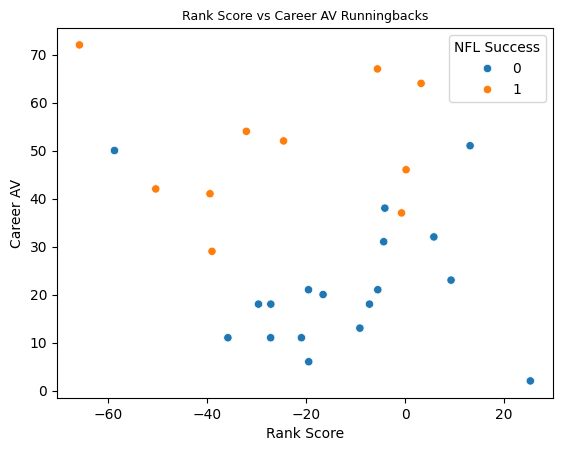

RECEIVERS:


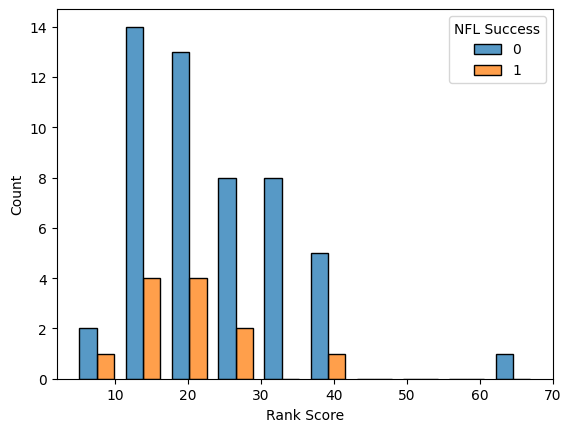

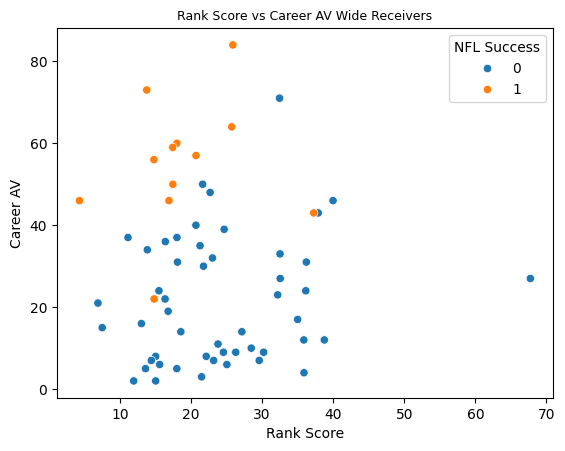

LINEBACKERS:


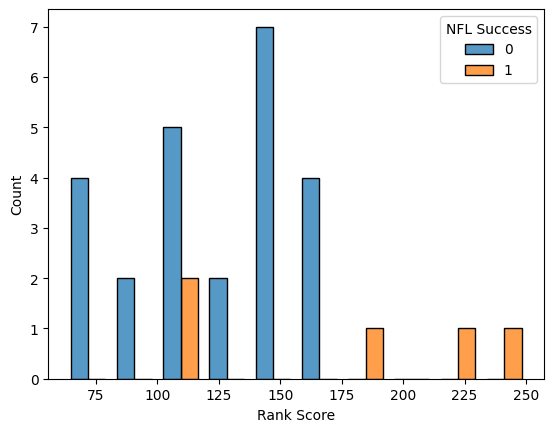

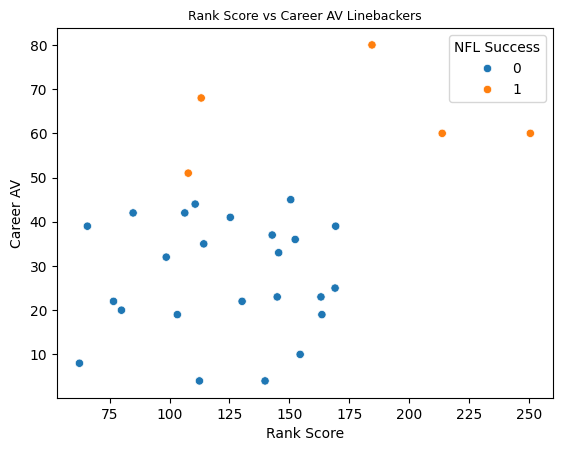

EDGE RUSHERS:


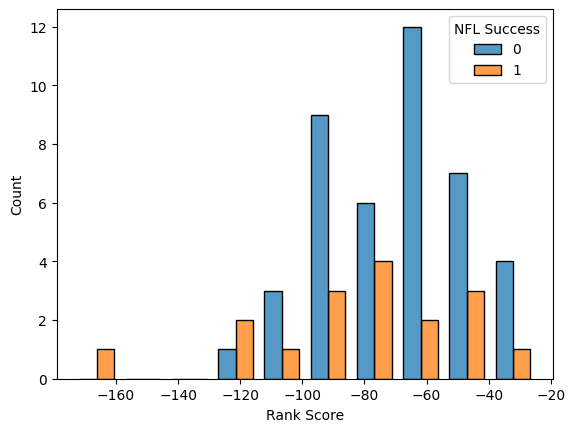

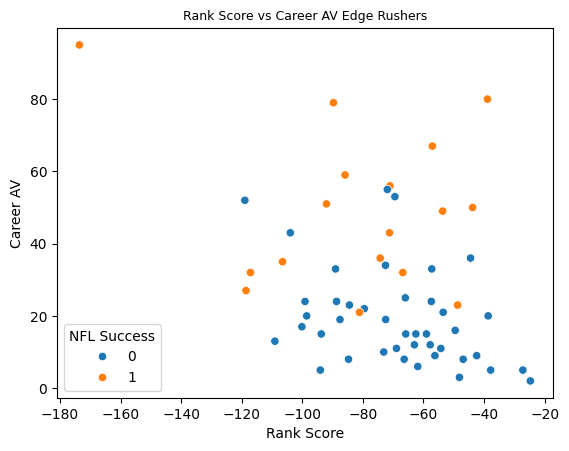

CORNERBACKS:


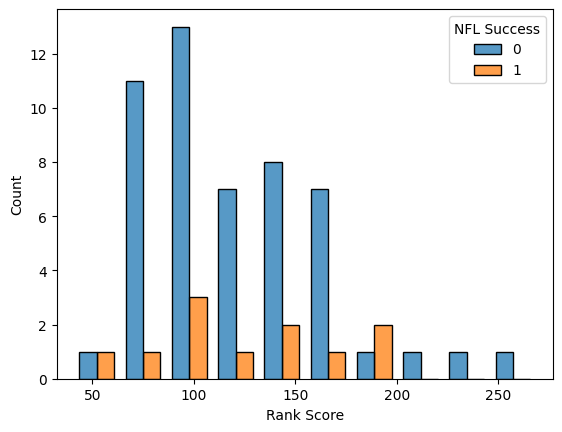

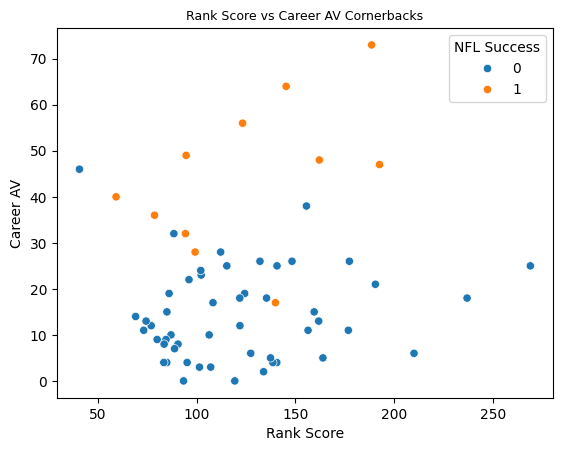

SAFETIES:


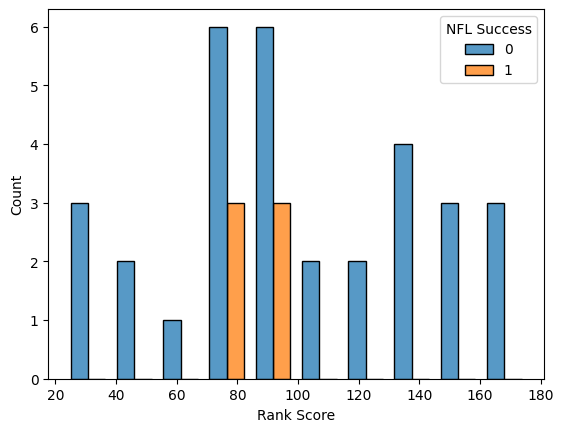

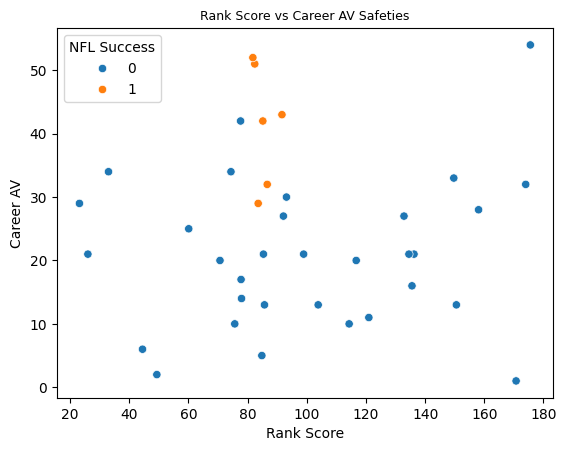

DEFENSIVE TACKLES:


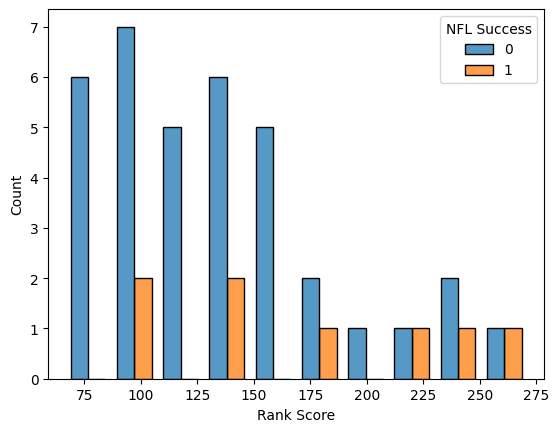

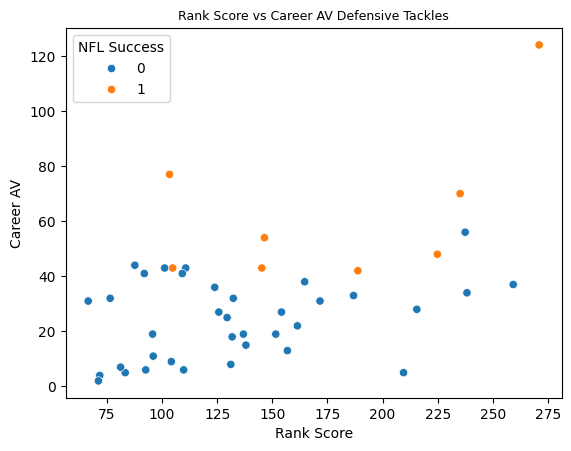

In [ ]:
quarterbacks = data[data['Position'] == 'QB']
runningbacks = data[data['Position'] == 'RB']
receivers = data[data['Position'] == 'WR']
linebackers = data[data['Position'] == 'LB']
edge_rushers = data[data['Position'] == 'ED']
cornerbacks = data[data['Position'] == 'CB']
safeties = data[data['Position'] == 'S']
defensive_tackles = data[data['Position'] == 'DT']

qb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
]

qb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

wr_rb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

wr_rb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

defense_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C'
]

defense_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C'
]

quarterbacks = quarterbacks[qb_features]
runningbacks = runningbacks[wr_rb_features]
receivers = receivers[wr_rb_features]
linebackers = linebackers[defense_features]
edge_rushers = edge_rushers[defense_features]
cornerbacks = cornerbacks[defense_features]
safeties = safeties[defense_features]
defensive_tackles = defensive_tackles[defense_features]

print('QUARTERBACKS:')
mod_urmc_wrapper(quarterbacks, qb_features, qb_features_wo_success, 'Quarterbacks')

print('RUNNINGBACKS:')
mod_urmc_wrapper(runningbacks, wr_rb_features, wr_rb_features_wo_success, 'Runningbacks')

print('RECEIVERS:')
mod_urmc_wrapper(receivers, wr_rb_features, wr_rb_features_wo_success, 'Wide Receivers')

print('LINEBACKERS:')
mod_urmc_wrapper(linebackers, defense_features, defense_features_wo_success, 'Linebackers')

print('EDGE RUSHERS:')
mod_urmc_wrapper(edge_rushers, defense_features, defense_features_wo_success, 'Edge Rushers')

print('CORNERBACKS:')
mod_urmc_wrapper(cornerbacks, defense_features, defense_features_wo_success, 'Cornerbacks')

print('SAFETIES:')
mod_urmc_wrapper(safeties, defense_features, defense_features_wo_success, 'Safeties')

print('DEFENSIVE TACKLES:')
mod_urmc_wrapper(defensive_tackles, defense_features, defense_features_wo_success, 'Defensive Tackles')

###Quarterbacks

In [ ]:
qb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

qb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

quarterbacks = quarterbacks[qb_features]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
quarterbacks_normalized = quarterbacks

for feature in qb_features_wo_success:
  col_min = min(quarterbacks[feature])
  col_max = max(quarterbacks[feature])
  for i, observation in quarterbacks.iterrows():
    new_obs = 1 + (9 * ((observation[feature] - col_min) / (col_max - col_min)))
    quarterbacks_normalized.at[i, feature] = new_obs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
quarterbacks_normalized_corr = quarterbacks_normalized.drop(['NFL Success V2'], axis=1).corr()
quarterbacks_normalized_corr.style.background_gradient()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
quarterbacks_normalized_corr_dict = {}

for i in range(len(qb_features_wo_success)):
  for j in range(len(qb_features_wo_success)):
    corr = quarterbacks_normalized_corr.at[qb_features_wo_success[i], qb_features_wo_success[j]]
    if corr not in quarterbacks_normalized_corr_dict.values() and corr != 1:
      quarterbacks_normalized_corr_dict.update({f'{i}:{j}':corr})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
quarterbacks_normalized_corr_dict = dict(sorted(quarterbacks_normalized_corr_dict.items(), key=lambda x:x[1], reverse=True))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
qb_weights = modified_urmc(quarterbacks_normalized_corr_dict, qb_features_wo_success)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
qb_rank_scores = calc_rank_score(quarterbacks_normalized, qb_weights, qb_features_wo_success)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(qb_rank_scores)

{105: 66.52809080811808, 266: 4.724476048952626, 158: -6.698747479301906, 278: -14.584630734049707, 320: -15.706622444294409, 317: -44.51955924978665, 219: -49.42371759706903, 204: -55.949260449118675, 1: -61.57295276895417, 16: -62.97916075845525, 216: -72.39057409142329, 53: -76.57336988512472, 361: -81.56359018800475, 54: -85.16685511645014, 239: -103.36796244686822, 124: -104.42764568287336, 26: -108.04909152651166, 321: -112.25779042320416, 336: -112.36876648585445, 221: -117.83679227765967, 271: -122.35008615439703, 168: -122.77156095502454, 214: -126.20534071891443, 166: -134.2303768927397, 145: -136.0213816147534, 28: -137.83108612953737, 297: -155.409695930785, 104: -163.6414009976725, 51: -199.9067996843368}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = pd.DataFrame()
for key in qb_rank_scores.keys():
  temp_df = pd.DataFrame([{'Name': data.at[key, 'Player'], 'Rank Score': qb_rank_scores[key], 'NFL Success': data.at[key, 'NFL Success V2']}])
  df = pd.concat([df,temp_df])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df2 = df[df['NFL Success'] == 1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[<Axes: title={'center': 'Rank Score'}>]], dtype=object)

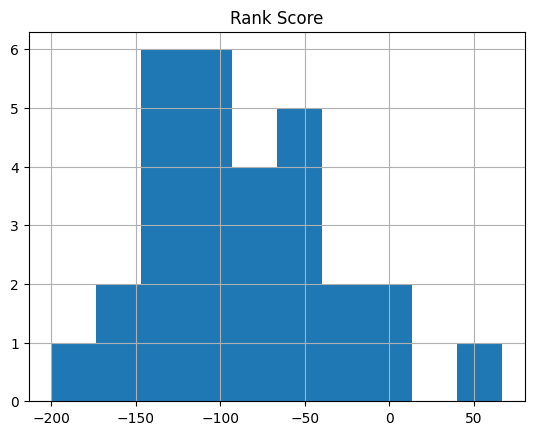

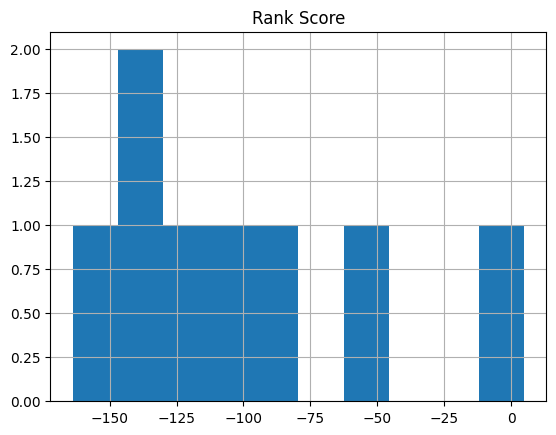

In [ ]:
df.hist(column='Rank Score')
df2.hist(column='Rank Score')

###Wide Receivers

In [ ]:
wr_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

wr_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

receivers = receivers[wr_features]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
receivers_normalized = receivers

for feature in wr_features_wo_success:
  col_min = min(receivers[feature])
  col_max = max(receivers[feature])
  for i, observation in receivers.iterrows():
    new_obs = 1 + (9 * ((observation[feature] - col_min) / (col_max - col_min)))
    receivers_normalized.at[i, feature] = new_obs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
receivers_normalized_corr = receivers_normalized.drop(['NFL Success V2'], axis=1).corr()
receivers_normalized_corr.style.background_gradient()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
receivers_normalized_corr_dict = {}

for i in range(len(wr_features_wo_success)):
  for j in range(len(wr_features_wo_success)):
    corr = receivers_normalized_corr.at[wr_features_wo_success[i], wr_features_wo_success[j]]
    if corr not in receivers_normalized_corr_dict.values() and corr != 1:
      receivers_normalized_corr_dict.update({f'{i}:{j}':corr})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
receivers_normalized_corr_dict = dict(sorted(receivers_normalized_corr_dict.items(), key=lambda x:x[1], reverse=True))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
wr_weights = modified_urmc(receivers_normalized_corr_dict, wr_features_wo_success)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
wr_rank_scores = calc_rank_score(receivers_normalized, wr_weights, wr_features_wo_success)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(wr_rank_scores)

{192: 67.73267861783172, 149: 39.987608537382975, 253: 38.762331854838074, 2: 37.90580062991263, 294: 37.27549334607734, 161: 36.23307896775702, 190: 36.156760475078194, 314: 35.906745719898815, 350: 35.87914378682869, 31: 35.01559427777576, 136: 32.55938543158728, 233: 32.53264733155655, 14: 32.46629353796825, 34: 32.210121475428785, 311: 30.22957930172982, 291: 29.611892467287667, 332: 28.489394611768013, 365: 27.16926721801139, 120: 26.306190644296414, 43: 25.902607338547742, 56: 25.738201724895834, 115: 25.0595748471549, 250: 24.677922154728165, 247: 24.57582233689174, 262: 23.8133269651115, 165: 23.199491335981698, 343: 23.034602219011788, 50: 22.70636535961717, 121: 22.155024610591788, 243: 21.771121512060365, 231: 21.65837571478749, 58: 21.512452278225886, 68: 21.287865402481415, 304: 20.717136977524614, 213: 20.708924064648166, 35: 18.58675426409664, 342: 18.11195312196321, 163: 18.038187892567887, 143: 18.029607228165105, 366: 18.02536131168687, 329: 17.465952065510237, 8: 17.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = pd.DataFrame()
for key in wr_rank_scores.keys():
  temp_df = pd.DataFrame([{'Name': data.at[key, 'Player'], 'Rank Score': wr_rank_scores[key], 'NFL Success': data.at[key, 'NFL Success V2']}])
  df = pd.concat([df,temp_df])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df2 = df[df['NFL Success'] == 1]
df3 = df[df['Rank Score'] <= 10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[<Axes: title={'center': 'Rank Score'}>]], dtype=object)

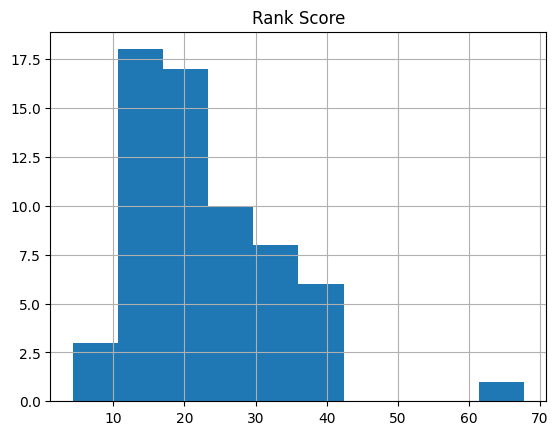

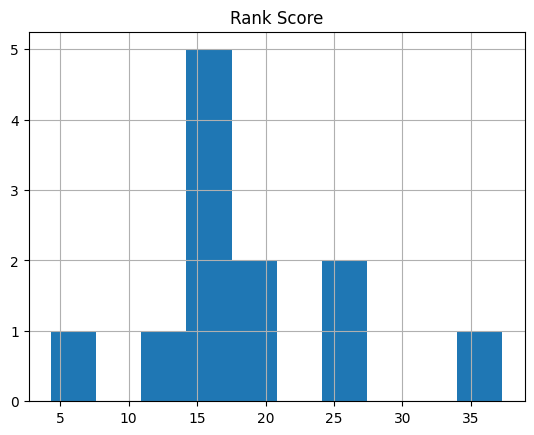

In [ ]:
df.hist(column='Rank Score')
df2.hist(column='Rank Score')

In [ ]:
df3.sort_values('NFL Success', ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

Name  Rank Score  NFL Success
0      D.K. Metcalf    4.331834            1
0  Breshad Perriman    7.532933            0
0          DJ Chark    6.932135            0

## Number of NFL Successes and Failures by Conference

In [ ]:
conference_success = {}

conferences = ['SEC', 'Big Ten', 'Pac-12', 'ACC', 'Big 12', 'American', 'MWC', 'MAC', 'CUSA', 'Sun Belt', 'Ind', 'FCS', 'D-II']
conference_success = {conference: 0 for conference in conferences}
conference_no_success = {conference: 0 for conference in conferences}

for i, player in data.iterrows():
  if player['Position'] != '':
    if player['NFL Success V2'] == 0:
      conference_no_success[player['Conference']] += 1
    conference_success[player['Conference'] ] += player['NFL Success V2']
print(conference_success)

success_list = list(conference_success.values())
no_success_list = list(conference_no_success.values())
#success_rates = [x/(x+y) for x in success_list for y in no_success_list]

{'SEC': 30, 'Big Ten': 14, 'Pac-12': 8, 'ACC': 13, 'Big 12': 6, 'American': 1, 'MWC': 4, 'MAC': 1, 'CUSA': 0, 'Sun Belt': 0, 'Ind': 0, 'FCS': 1, 'D-II': 0}


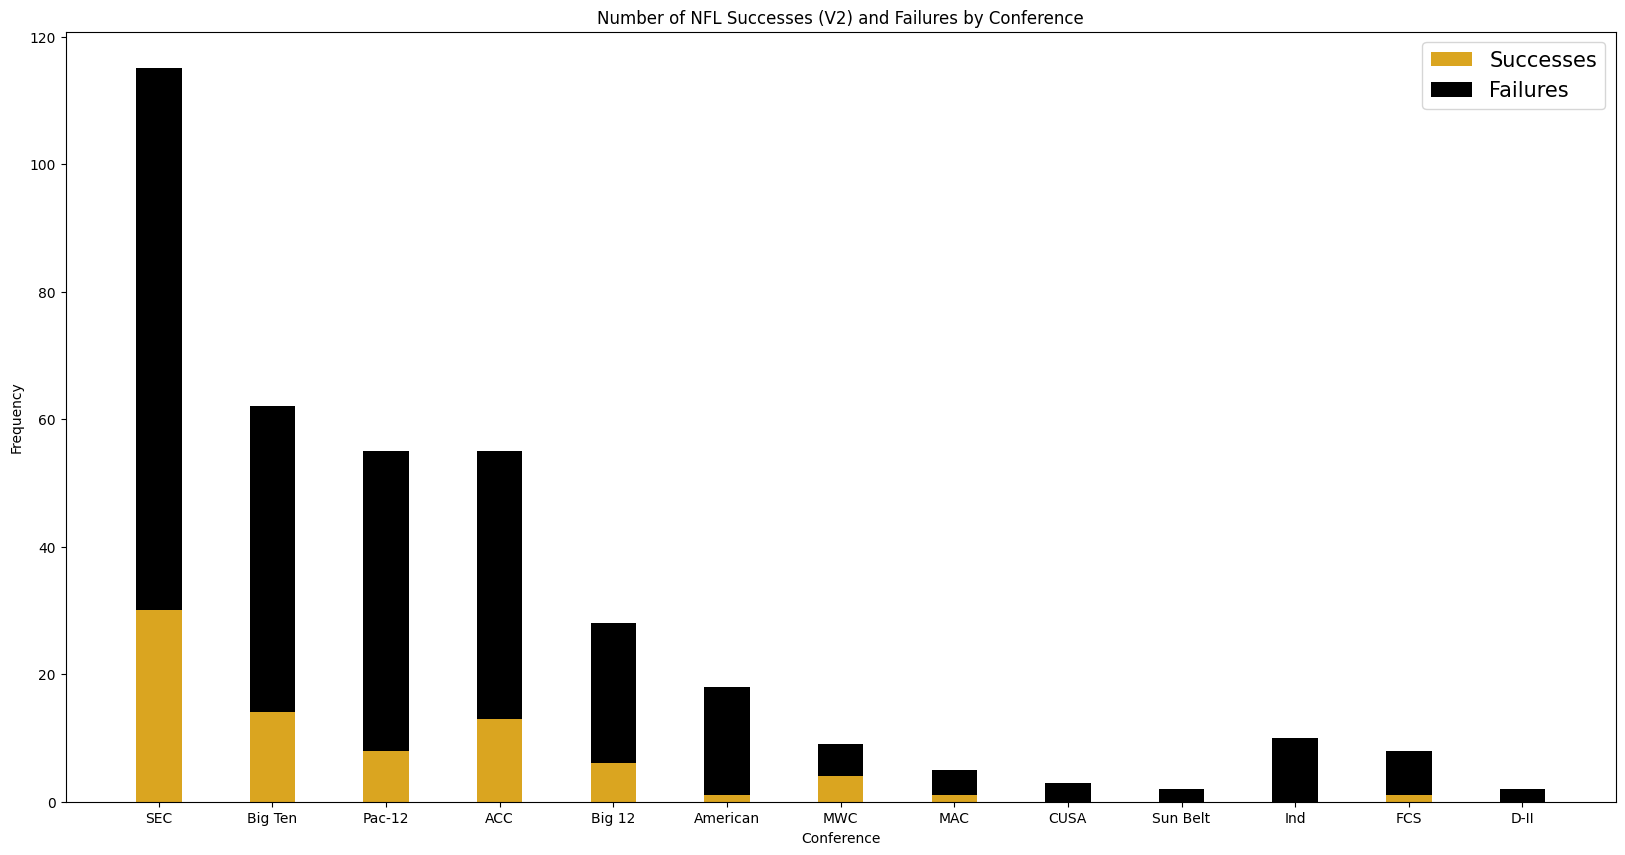

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.bar(conferences, success_list, width=.4, color='goldenrod', label='Successes')
plt.bar(conferences, no_success_list, bottom=success_list, width=.4, color='black', label='Failures')
plt.title('Number of NFL Successes (V2) and Failures by Conference')
plt.xlabel('Conference')
plt.ylabel('Frequency')
plt.legend(fontsize='15', loc='upper right')
plt.show()

{2014: 12, 2015: 7, 2016: 11, 2017: 11, 2018: 8, 2019: 5, 2020: 5}


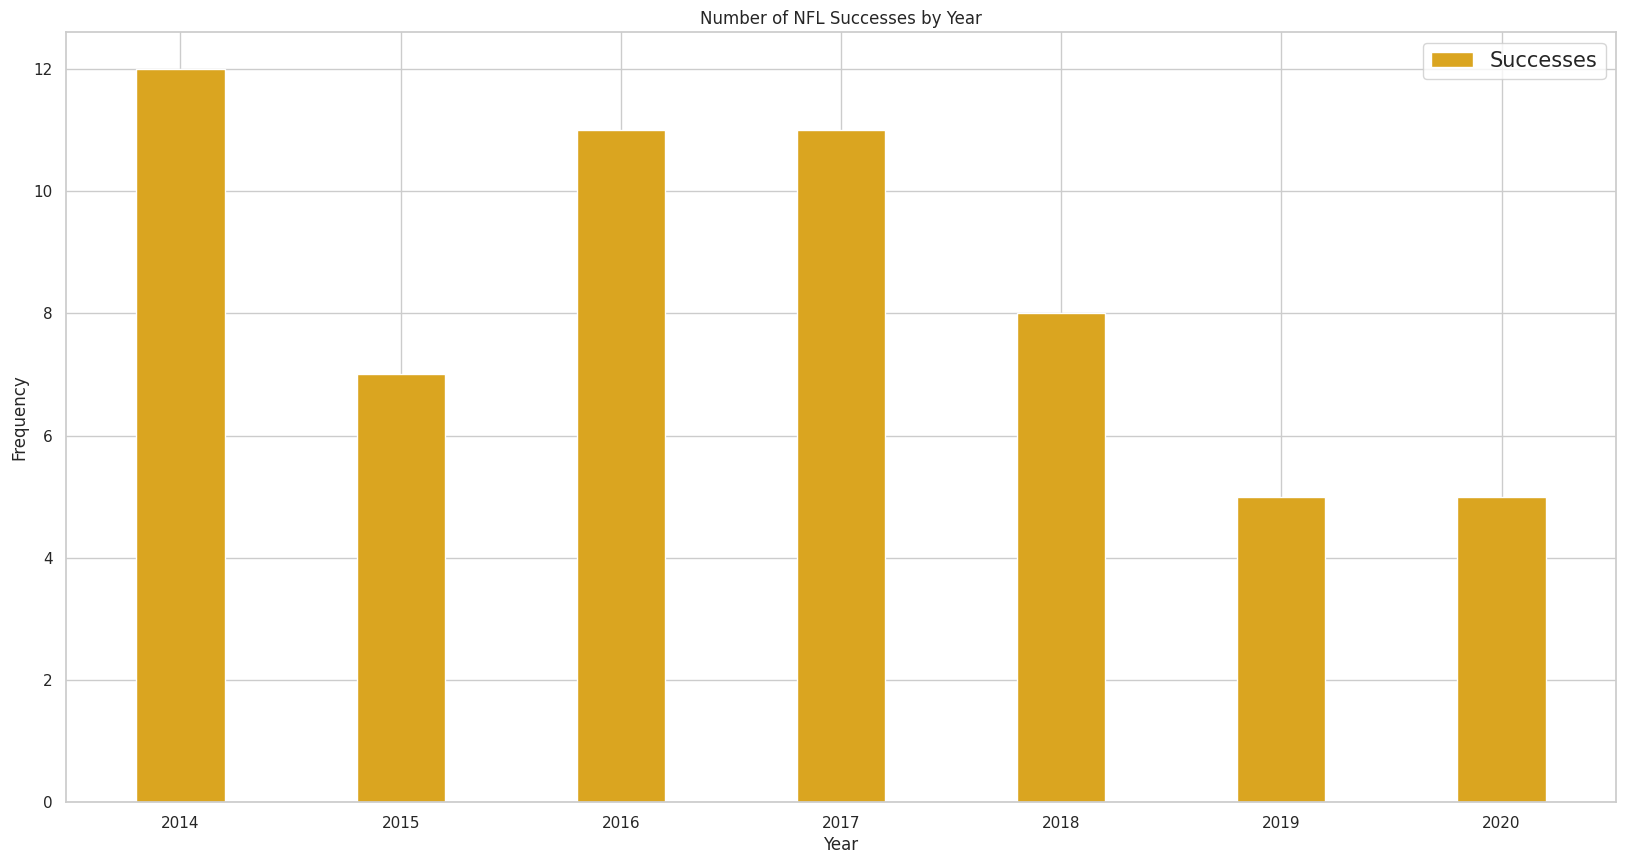

In [ ]:
years = {2014:0, 2015:0, 2016:0, 2017:0, 2018:0, 2019:0, 2020:0}
for i, player in data.iterrows():
  if player['Position'] != '':
    if player['NFL Success'] == 1:
      years[player['Draft Year']] += 1
print(years)

fig = plt.figure(figsize = (20, 10))
plt.bar(years.keys(), years.values(), width=.4, color='goldenrod', label='Successes')
plt.title('Number of NFL Successes by Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(fontsize='15', loc='upper right')
plt.show()

##Correlations

In [ ]:
quarterbacks = data[data['Position'] == 'QB']
runningbacks = data[data['Position'] == 'RB']
receivers = data[data['Position'] == 'WR']
linebackers = data[data['Position'] == 'LB']
edge_rushers = data[data['Position'] == 'ED']
cornerbacks = data[data['Position'] == 'CB']
safeties = data[data['Position'] == 'S']
defensive_tackles = data[data['Position'] == 'DT']

In [ ]:
qb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships', 'Relative Athletic Score',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

wr_rb_te_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships', 'Relative Athletic Score',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

defense_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships', 'Relative Athletic Score',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C',
]

features = [
    'Age', 'College Accolades', 'National Championships', 'Relative Athletic Score',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]


In [ ]:
quarterbacks = quarterbacks[qb_features]

nfl_qb_stats = [
    'All-Pros', 'Pro Bowls', 'Completions_NFL', 'Passing Attempts_NFL', 'Completion Pct_NFL', 'Passing Yards_NFL', 'Passing Yards per Attempt_NFL',
    'Adj Passing Yards per Attempt_NFL', 'Passing Touchdowns_NFL', 'Interceptions_NFL', 'Passer Rating_NFL',
    'Rushing Attempts_NFL', 'Rushing Yards_NFL' , 'Rushing Yards per Attempt_NFL', 'Rushing TDs_NFL'
]

for qb_stat in nfl_qb_stats:
  quarterbacks[qb_stat] = quarterbacks[qb_stat].rank(pct=True)

quarterbacks['NFL Stats Composite Ranking'] = 100 * quarterbacks[nfl_qb_stats].mean(axis=1)
quarterbacks.to_csv('quarterbacks.csv')

<ipython-input-16-838a5e5bb70f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quarterbacks[qb_stat] = quarterbacks[qb_stat].rank(pct=True)
<ipython-input-16-838a5e5bb70f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quarterbacks['NFL Stats Composite Ranking'] = 100 * quarterbacks[nfl_qb_stats].mean(axis=1)


In [ ]:
dfi.export(quarterbacks[['Player', 'NFL Stats Composite Ranking']].sort_values(by='NFL Stats Composite Ranking', ascending=False).style.background_gradient(), 'qb_composites.png', table_conversion="matplotlib")

In [ ]:
qb_corr = quarterbacks[qb_features]
qb_corr = qb_corr.corr()['NFL Success V2'].to_frame()
qb_corr = qb_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
qb_corr.style.background_gradient()

Text(0.5, 1.0, 'College Rushing Yards vs College Rushing Attempts')

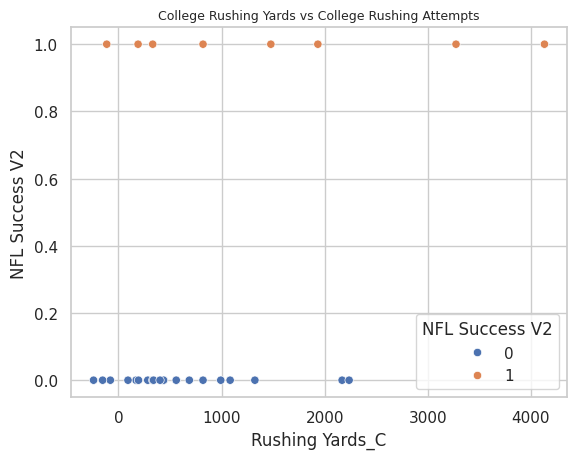

In [ ]:
sns.set(style='whitegrid')
sns.scatterplot(data=quarterbacks, x='Rushing Yards_C', y='NFL Success V2', hue='NFL Success V2').set_title('College Rushing Yards vs College Rushing Attempts', fontsize=9)

In [ ]:
runningbacks = runningbacks[wr_rb_te_features]

nfl_rb_stats = [
    'Receptions_NFL', 'Receiving Yards_NFL', 'Receiving Yards per Attempt_NFL', 'Receiving Touchdowns_NFL',
    'Rushing Attempts_NFL', 'Rushing Yards_NFL' , 'Rushing Yards per Attempt_NFL', 'Rushing TDs_NFL'
]

for rb_stat in nfl_rb_stats:
  runningbacks[rb_stat] = runningbacks[rb_stat].rank(pct=True)

runningbacks['NFL Stats Composite Ranking'] = runningbacks[nfl_rb_stats].mean(axis=1)
runningbacks.to_csv('runningbacks.csv')

<ipython-input-47-632798ad5aa9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runningbacks[rb_stat] = runningbacks[rb_stat].rank(pct=True)
<ipython-input-47-632798ad5aa9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runningbacks['NFL Stats Composite Ranking'] = runningbacks[nfl_rb_stats].mean(axis=1)


In [ ]:
rb_corr = runningbacks[wr_rb_te_features].corr()['NFL Success V2'].to_frame()
rb_corr = rb_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
rb_corr.style.background_gradient()

Text(0.5, 1.0, 'College Receiving Yards vs College Receiving Yards per Attemp')

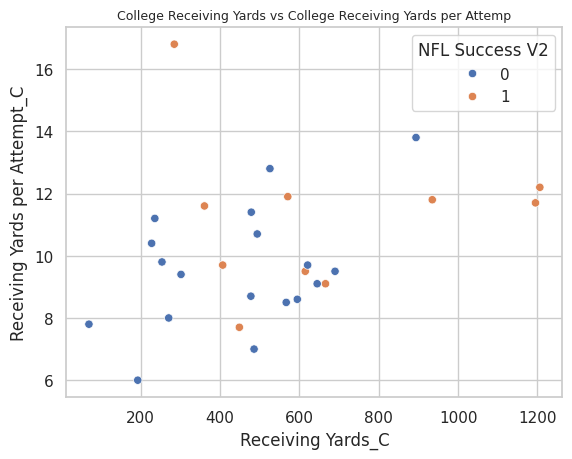

In [ ]:
sns.set(style='whitegrid')
sns.scatterplot(data=runningbacks, x='Receiving Yards_C', y='Receiving Yards per Attempt_C', hue='NFL Success V2').set_title('College Receiving Yards vs College Receiving Yards per Attemp', fontsize=9)

In [ ]:
receivers = receivers[wr_rb_te_features]
wr_corr = receivers.corr()['NFL Success V2'].to_frame()
wr_corr = wr_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
wr_corr.style.background_gradient()

In [ ]:
linebackers = linebackers[defense_features]

nfl_defense_stats = [
    'Receptions_NFL', 'Receiving Yards_NFL', 'Receiving Yards per Attempt_NFL', 'Receiving Touchdowns_NFL',
    'Rushing Attempts_NFL', 'Rushing Yards_NFL' , 'Rushing Yards per Attempt_NFL', 'Rushing TDs_NFL'
]

#for rb_stat in nfl_rb_stats:
  #runningbacks[rb_stat] = runningbacks[rb_stat].rank(pct=True)

#runningbacks['NFL Stats Composite Ranking'] = runningbacks[nfl_rb_stats].mean(axis=1)
#runningbacks.to_csv('runningbacks.csv')

In [ ]:
linebackers = linebackers[defense_features]
lb_corr = linebackers.corr()['NFL Success V2'].to_frame()
lb_corr = lb_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
lb_corr.style.background_gradient()

Text(0.5, 1.0, 'Passes Defended_C vs Defensive Interceptions_C')

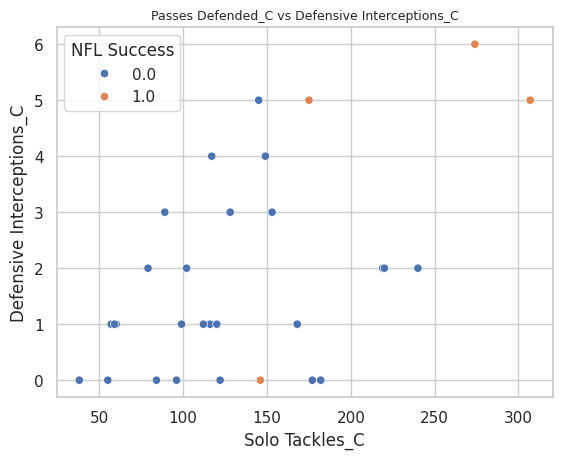

In [ ]:
sns.set(style='whitegrid')
sns.scatterplot(data=linebackers, x='Solo Tackles_C', y='Defensive Interceptions_C', hue='NFL Success').set_title('Passes Defended_C vs Defensive Interceptions_C', fontsize=9)

In [ ]:
edge_rushers = edge_rushers[defense_features]
de_corr = edge_rushers.corr(method='pearson')['NFL Success V2'].to_frame()
de_corr = de_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
de_corr.style.background_gradient()

In [ ]:
cornerbacks = cornerbacks[defense_features]
cb_corr = cornerbacks.corr(method='pearson')['NFL Success V2'].to_frame()
cb_corr = cb_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
cb_corr.style.background_gradient()

In [ ]:
cornerbacks = cornerbacks[defense_features]
cb_corr = cornerbacks.corr(method='pearson')['NFL Success V2'].to_frame()
cb_corr = cb_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
cb_corr.style.background_gradient()

##KNN

In [ ]:
def knn(player_data, features, features_wo_success):
  player_data_normalized = player_data[features]

  for feature in features_wo_success:
    feature_normalized = normalize([list(player_data[feature])], norm='l1')
    i = 0
    for idx in player_data_normalized.index:
      player_data_normalized.at[idx, feature] = feature_normalized[0][i]
      i += 1

  X = player_data[features_wo_success]
  y = player_data['NFL Success V2']
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

  # Fit the RandomForestClassifier after ensuring no NaNs are present
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  rf.fit(X_train, y_train)

  # Standardize the data
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Select the most important features
  selector = SelectFromModel(rf, prefit=True, max_features=2)
  X_train_selected = selector.transform(X_train)
  X_test_selected = selector.transform(X_test)

  #Finds the most accurate k value between 2 and 7
  k_vals = [2, 2, 3, 4, 5, 6, 7]
  best_k = [0, 1]

  for k in k_vals:
    k_classifier = KNeighborsClassifier(n_neighbors = k, algorithm = 'auto').fit(X_train_selected, y_train)
    y_pred = k_classifier.predict(X_test_selected)
    if accuracy_score(y_test, y_pred) > best_k[0]:
      best_k[0] = accuracy_score(y_test, y_pred)
      best_k[1] = k

  k_classifier = KNeighborsClassifier(n_neighbors = best_k[1], algorithm = 'auto').fit(X_train_selected, y_train)
  y_pred = k_classifier.predict(X_test_selected)
  #Prints the accuracy of the model
  print('k-value:', best_k[1], 'Accuracy:', accuracy_score(y_test, y_pred))

  #Creates a scatterplot of the two selected features
  selected_features = selector.get_feature_names_out(input_features=features_wo_success)
  sns.scatterplot(data=player_data, x=selected_features[0], y=selected_features[1], hue='NFL Success V2').set_title(f'{selected_features[0]} vs {selected_features[1]}', fontsize=9)
  plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


QUARTERBACKS:
k-value: 4 Accuracy: 0.8333333333333334


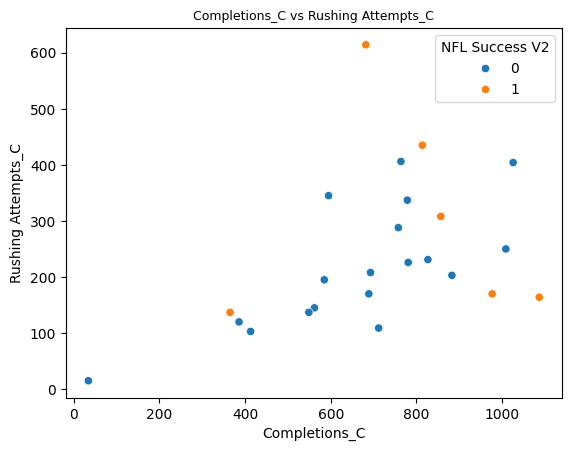

RUNNINGBACKS:
k-value: 2 Accuracy: 0.7142857142857143


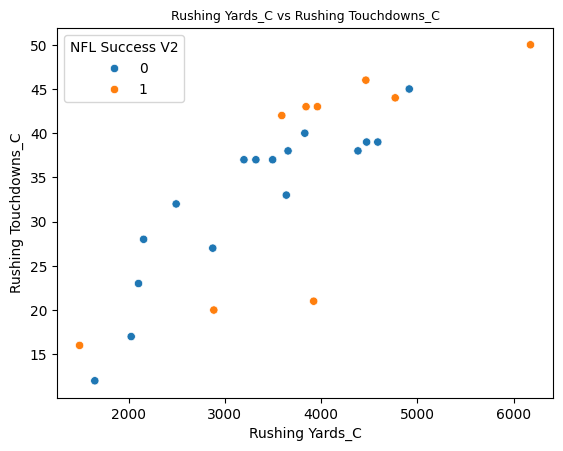

RECEIVERS:
k-value: 6 Accuracy: 0.7333333333333333


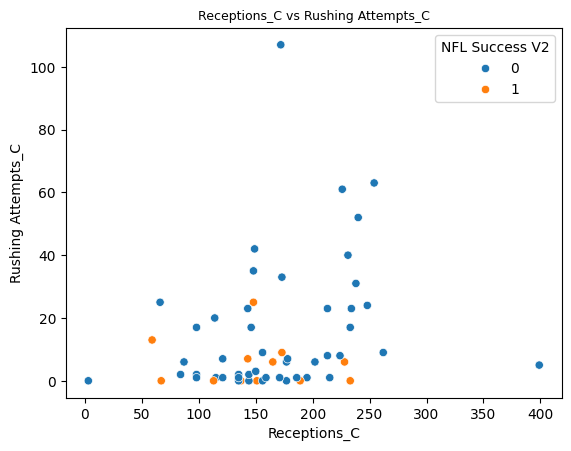

LINEBACKERS:
k-value: 7 Accuracy: 1.0


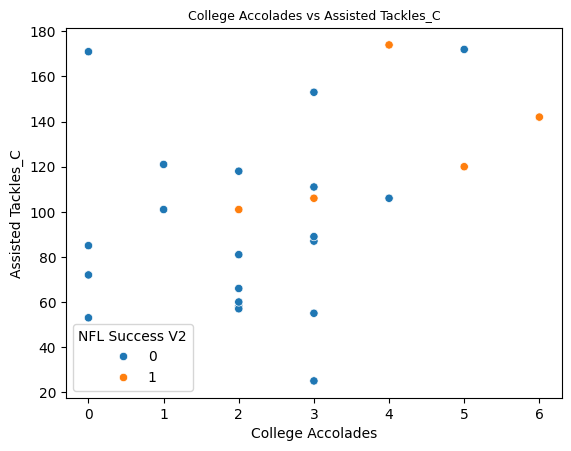

EDGE RUSHERS:
k-value: 2 Accuracy: 0.7857142857142857


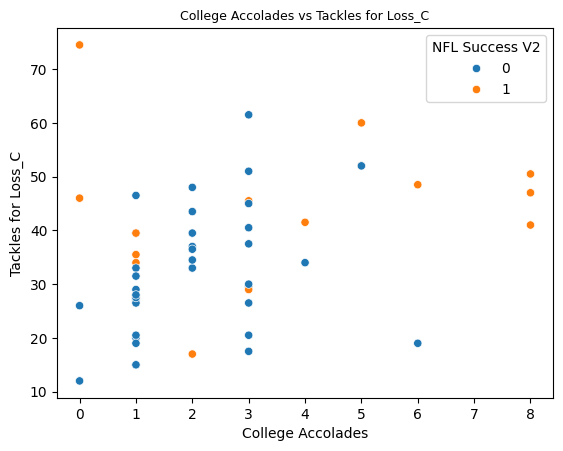

CORNERBACKS:
k-value: 2 Accuracy: 0.8


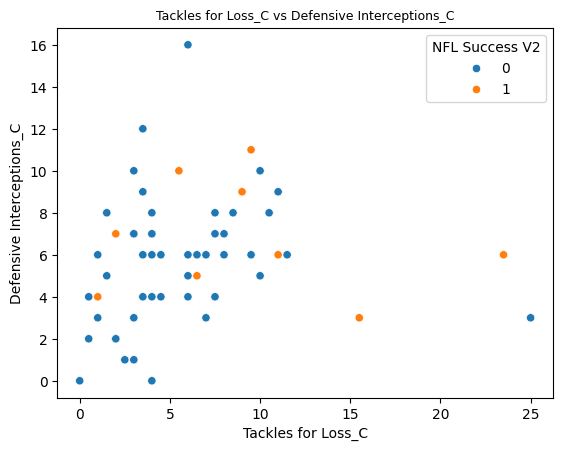

SAFETIES:
k-value: 2 Accuracy: 0.7777777777777778


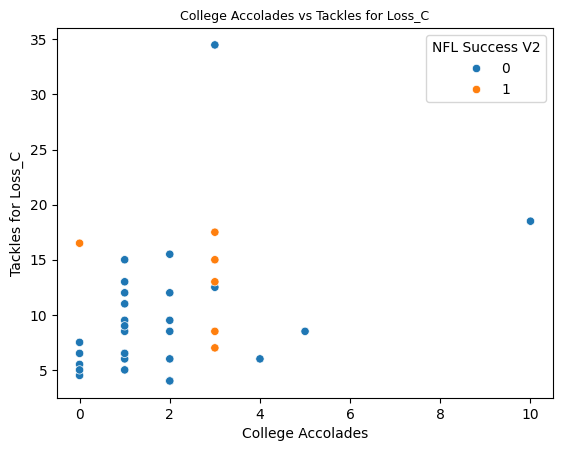

DEFENSIVE TACKLES:
k-value: 4 Accuracy: 0.8


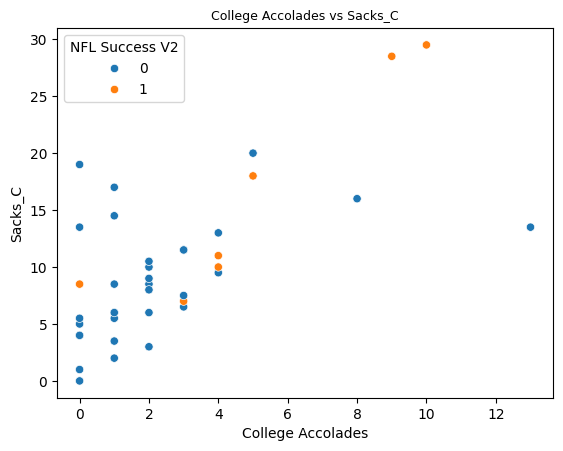

In [ ]:
quarterbacks = data[data['Position'] == 'QB']
runningbacks = data[data['Position'] == 'RB']
receivers = data[data['Position'] == 'WR']
linebackers = data[data['Position'] == 'LB']
edge_rushers = data[data['Position'] == 'ED']
cornerbacks = data[data['Position'] == 'CB']
safeties = data[data['Position'] == 'S']
defensive_tackles = data[data['Position'] == 'DT']

qb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
]

qb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

wr_rb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

wr_rb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

defense_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C'
]

defense_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C'
]

quarterbacks = quarterbacks[qb_features]
runningbacks = runningbacks[wr_rb_features]
receivers = receivers[wr_rb_features]
linebackers = linebackers[defense_features]
edge_rushers = edge_rushers[defense_features]
cornerbacks = cornerbacks[defense_features]
safeties = safeties[defense_features]
defensive_tackles = defensive_tackles[defense_features]

print('QUARTERBACKS:')
knn(quarterbacks, qb_features, qb_features_wo_success)

print('RUNNINGBACKS:')
knn(runningbacks, wr_rb_features, wr_rb_features_wo_success)

print('RECEIVERS:')
knn(receivers, wr_rb_features, wr_rb_features_wo_success)

print('LINEBACKERS:')
knn(linebackers, defense_features, defense_features_wo_success)

print('EDGE RUSHERS:')
knn(edge_rushers, defense_features, defense_features_wo_success)

print('CORNERBACKS:')
knn(cornerbacks, defense_features, defense_features_wo_success)

print('SAFETIES:')
knn(safeties, defense_features, defense_features_wo_success)

print('DEFENSIVE TACKLES:')
knn(defensive_tackles, defense_features, defense_features_wo_success)

###Cornerbacks

In [ ]:
data = pd.read_csv('Players.csv').dropna()

cornerbacks = data[data['Position'] == 'CB']

cb_features = [
    'NFL Success V2', 'College Accolades', 'Relative Athletic Score',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C',
]
cb_features_wo_success = [
    'College Accolades', 'Relative Athletic Score',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C',
]

cornerbacks_normalized = cornerbacks[cb_features]

for feature in ed_features_wo_success:
  feature_normalized = normalize([list(cornerbacks[feature])], norm='l1')
  i = 0
  for idx in cornerbacks_normalized.index:
    cornerbacks_normalized.at[idx, feature] = feature_normalized[0][i]
    i += 1

X = cornerbacks_normalized[cb_features_wo_success]
y = cornerbacks_normalized['NFL Success V2']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=8)

k_regressor = KNeighborsClassifier(n_neighbors = 3, algorithm = 'auto').fit(X_train, y_train)

y_pred = k_regressor.predict(X_test)

print(y_pred)
print(y_test)
print(accuracy_score(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-155-675394c734fe>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cornerbacks_normalized.at[idx, feature] = feature_normalized[0][i]
<ipython-input-155-675394c734fe>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

ValueError: could not convert string to float: 'Big 12'

###Wide Receivers

In [ ]:
data = pd.read_csv('Players.csv').dropna()

widereceivers = data[data['Position'] == 'WR']

wr_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships', 'Relative Athletic Score',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

wr_features_wo_success = [
    'Age', 'College Accolades', 'National Championships', 'Relative Athletic Score',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

widereceivers_normalized = widereceivers[wr_features]

for feature in wr_features_wo_success:
  feature_normalized = normalize([list(widereceivers[feature])], norm='l1')
  i = 0
  for idx in widereceivers_normalized.index:
    widereceivers_normalized.at[idx, feature] = feature_normalized[0][i]
    i += 1

X = widereceivers_normalized[wr_features_wo_success]
y = widereceivers_normalized['NFL Success V2']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2)

k_regressor = KNeighborsClassifier(n_neighbors = 2, algorithm = 'auto').fit(X_train, y_train)

y_pred = k_regressor.predict(X_test)

print(y_pred)
print(y_test)

###Edge Rushers

In [ ]:
data = pd.read_csv('Players.csv').dropna()

edgerushers = data[data['Position'] == 'ED']

ed_features = [
    'NFL Success V2', 'College Accolades', 'Relative Athletic Score',
    'Solo Tackles_C', 'Tackles for Loss_C', 'Sacks_C', 'Forced Fumbles_C'
]

ed_features_wo_success = [
    'College Accolades', 'Relative Athletic Score',
    'Solo Tackles_C', 'Tackles for Loss_C', 'Sacks_C', 'Forced Fumbles_C'
]

edgerushers_normalized = edgerushers[ed_features]

for feature in ed_features_wo_success:
  feature_normalized = normalize([list(edgerushers[feature])], norm='l1')
  i = 0
  for idx in edgerushers_normalized.index:
    edgerushers_normalized.at[idx, feature] = feature_normalized[0][i]
    i += 1

X = edgerushers_normalized[ed_features_wo_success]
y = edgerushers_normalized['NFL Success V2']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=7)

k_regressor = KNeighborsClassifier(n_neighbors = 3, algorithm ='brute').fit(X_train, y_train)

y_pred = k_regressor.predict(X_test)

print(accuracy_score(y_test, y_pred))

###Linebackers

In [ ]:
linebackers_knn = data[data['Position'] == 'LB']

lb_features_knn = [
    'NFL Success V2', 'College Accolades', 'Solo Tackles_C'
]

lb_features_wo_success_knn = [
    'College Accolades', 'Solo Tackles_C'
]

X = linebackers_knn[lb_features_wo_success_knn]
y = linebackers_knn['NFL Success V2']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

k_regressor = KNeighborsClassifier(n_neighbors = 2, algorithm ='auto').fit(X_train, y_train)

y_pred = k_regressor.predict(X_test)

print(y_test)
print(y_pred)

print(accuracy_score(y_test, y_pred))

###Quarterbacks

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score

data = pd.read_csv('Players.csv').dropna()

quarterbacks = data[data['Position'] == 'QB']

qb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships', 'Relative Athletic Score',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

qb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships', 'Relative Athletic Score',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C'
]

quarterbacks_normalized = quarterbacks[qb_features]

for feature in qb_features_wo_success:
  feature_normalized = normalize([list(quarterbacks[feature])], norm='l1')
  i = 0
  for idx in quarterbacks_normalized.index:
    quarterbacks_normalized.at[idx, feature] = feature_normalized[0][i]
    i += 1

X = quarterbacks_normalized[qb_features_wo_success]
y = quarterbacks_normalized['NFL Success V2']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=10)

k_regressor = KNeighborsClassifier(n_neighbors = 4, algorithm = 'auto').fit(X_train, y_train)

y_pred = k_regressor.predict(X_test)

print(y_pred)
print(y_test)
print(accuracy_score(y_test, y_pred))

##Logistic Regression

In [3]:
data = pd.read_csv('Players.csv')

In [28]:
def log_regression(position_data, features, features_wo_success):
  warnings.filterwarnings('always')
  #Transform conference column into dummy variables
  conference_dummies = pd.get_dummies(position_data['Conference'])
  conference_dummies = conference_dummies.astype(int)
  position_data = pd.concat((position_data, conference_dummies), axis=1).drop(['Conference'], axis=1)

  #Display correlations between each variable and NFL Success V2
  position_data_corr = position_data.corr()['NFL Success V2'].to_frame()
  position_data_corr = position_data_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
  display(position_data_corr.style.background_gradient())

  #Create the new list of features with the conference dummy columns
  features = list(position_data.columns)
  features_wo_success = features[1:]

  #Split the data into training and testing data
  X = position_data[features_wo_success]
  y = position_data['NFL Success V2']
  X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Fit the RandomForestClassifier after ensuring no NaNs are present
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  rf.fit(X_train, Y_train)

  # Standardize the data
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Select the most important features
  selector = SelectFromModel(rf, prefit=True)
  X_train_selected = selector.transform(X_train)
  X_test_selected = selector.transform(X_test)

  # Logistic regression model
  log_reg = LogisticRegression(max_iter=10000)
  log_reg.fit(X_train_selected, Y_train)

  #Prints out the selected features
  feature_idices = selector.get_support()
  print('SELECTED FEATURES:')
  count = 0
  for i in range(len(features_wo_success)):
    if feature_idices[i]:
      print(features_wo_success[i], " ", round(log_reg.coef_[0][count], 6))
      count += 1

  # Predictions and evaluation
  Y_pred = log_reg.predict(X_test_selected)
  accuracy = accuracy_score(Y_test, Y_pred)

  print("Accuracy:", accuracy)
  try:
    roc_auc = roc_auc_score(Y_test, Y_pred)
    print("ROC AUC Score:", roc_auc)
  except:
    pass
  print("Classification Report:\n", classification_report(Y_test, Y_pred))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
quarterbacks = data[data['Position'] == 'QB']
runningbacks = data[data['Position'] == 'RB']
receivers = data[data['Position'] == 'WR']
linebackers = data[data['Position'] == 'LB']
edge_rushers = data[data['Position'] == 'ED']
cornerbacks = data[data['Position'] == 'CB']
safeties = data[data['Position'] == 'S']
defensive_tackles = data[data['Position'] == 'DT']

qb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C', 'Conference'
]

qb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C', 'Conference'
]

wr_rb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
    'Conference'
]

wr_rb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
    'Conference'
]

defense_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships', 'Conference',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C'
]

defense_features_wo_success = [
    'Age', 'College Accolades', 'National Championships', 'Conference',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C'
]

quarterbacks = quarterbacks[qb_features]
runningbacks = runningbacks[wr_rb_features]
receivers = receivers[wr_rb_features]
linebackers = linebackers[defense_features]
edge_rushers = edge_rushers[defense_features]
cornerbacks = cornerbacks[defense_features]
safeties = safeties[defense_features]
defensive_tackles = defensive_tackles[defense_features]

print('QUARTERBACKS:')
log_regression(quarterbacks, qb_features, qb_features_wo_success)

print('RUNNINGBACKS:')
log_regression(runningbacks, wr_rb_features, wr_rb_features_wo_success)

print('RECEIVERS:')
log_regression(receivers, wr_rb_features, wr_rb_features_wo_success)

print('LINEBACKERS:')
log_regression(linebackers, defense_features, defense_features_wo_success)

print('EDGE RUSHERS:')
log_regression(edge_rushers, defense_features, defense_features_wo_success)

print('CORNERBACKS:')
log_regression(cornerbacks, defense_features, defense_features_wo_success)

print('SAFETIES:')
log_regression(safeties, defense_features, defense_features_wo_success)

print('DEFENSIVE TACKLES:')
log_regression(defensive_tackles, defense_features, defense_features_wo_success)

QUARTERBACKS:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SELECTED FEATURES:
College Accolades   -0.192287
Completions_C   0.008131
Passing Attempts_C   0.011942
Passing Yards per Attempt_C   -0.010766
Passing Touchdowns_C   0.158126
Passer Rating_C   -0.128005
Rushing Attempts_C   0.181881
Rushing Yards_C   0.765954
Rushing Yards per Attempt_C   0.128753
Rushing Touchdowns_C   -0.262456
Accuracy: 0.8333333333333334
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6

RUNNINGBACKS:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SELECTED FEATURES:
College Accolades   0.33296
Receptions_C   0.535261
Receiving Yards_C   0.595535
Receiving Yards per Attempt_C   0.478276
Receiving TDs_C   -0.007636
Rushing Attempts_C   -0.221267
Rushing Yards_C   0.306797
Rushing Yards per Attempt_C   -0.012136
Rushing Touchdowns_C   -0.051761
Accuracy: 0.6666666666666666
ROC AUC Score: 0.8
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.33      1.00      0.50         1

    accuracy                           0.67         6
   macro avg       0.67      0.80      0.62         6
weighted avg       0.89      0.67      0.71         6

RECEIVERS:


SELECTED FEATURES:
Age   -1.054515
College Accolades   0.120254
Receptions_C   -0.270274
Receiving Yards_C   0.027581
Receiving Yards per Attempt_C   0.365434
Receiving TDs_C   0.06835
Rushing Attempts_C   -0.730706
Rushing Yards_C   -0.401534
Rushing Yards per Attempt_C   -0.602479
SEC   0.947199
Accuracy: 0.7692307692307693
ROC AUC Score: 0.6166666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.50      0.33      0.40         3

    accuracy                           0.77        13
   macro avg       0.66      0.62      0.63        13
weighted avg       0.74      0.77      0.75        13

LINEBACKERS:


SELECTED FEATURES:
Age   -0.676045
College Accolades   1.044812
Solo Tackles_C   0.586625
Assisted Tackles_C   -0.115703
Total Tackles_C   0.352792
Tackles for Loss_C   0.115439
Sacks_C   0.311067
Defensive Interceptions_C   0.445104
Passes Defended_C   -0.19571
Forced Fumbles_C   -0.18435
Accuracy: 0.8333333333333334
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.00      0.00      0.00         0

    accuracy                           0.83         6
   macro avg       0.50      0.42      0.45         6
weighted avg       1.00      0.83      0.91         6

EDGE RUSHERS:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SELECTED FEATURES:
College Accolades   0.685634
Solo Tackles_C   -0.368864
Assisted Tackles_C   -0.2076
Total Tackles_C   -0.322227
Tackles for Loss_C   1.120693
Sacks_C   -0.274965
Passes Defended_C   -0.009542
Forced Fumbles_C   0.58936
Accuracy: 0.6666666666666666
ROC AUC Score: 0.5625
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.50      0.25      0.33         4

    accuracy                           0.67        12
   macro avg       0.60      0.56      0.56        12
weighted avg       0.63      0.67      0.63        12

CORNERBACKS:


SELECTED FEATURES:
Age   -0.211614
Solo Tackles_C   0.027618
Assisted Tackles_C   -0.850231
Total Tackles_C   -0.271188
Tackles for Loss_C   0.622164
Defensive Interceptions_C   0.212398
Passes Defended_C   -0.186755
Accuracy: 0.7692307692307693
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.00      0.00      0.00         3

    accuracy                           0.77        13
   macro avg       0.38      0.50      0.43        13
weighted avg       0.59      0.77      0.67        13

SAFETIES:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SELECTED FEATURES:
College Accolades   -0.184117
Solo Tackles_C   0.241849
Assisted Tackles_C   -0.331648
Total Tackles_C   0.041669
Tackles for Loss_C   0.502991
Sacks_C   0.051442
Defensive Interceptions_C   -0.821128
Passes Defended_C   0.667284
Fumble Recoveries_C   0.158779
SEC   0.517931
Accuracy: 0.875
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.00      0.00      0.00         1

    accuracy                           0.88         8
   macro avg       0.44      0.50      0.47         8
weighted avg       0.77      0.88      0.82         8

DEFENSIVE TACKLES:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SELECTED FEATURES:
Age   -0.455977
College Accolades   -0.137532
Solo Tackles_C   -0.015585
Assisted Tackles_C   0.493228
Total Tackles_C   0.247453
Tackles for Loss_C   0.776103
Sacks_C   0.174414
Passes Defended_C   0.32125
Fumble Recoveries_C   -0.991017
Forced Fumbles_C   -0.434185
Accuracy: 0.7777777777777778
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.00      0.00      0.00         2

    accuracy                           0.78         9
   macro avg       0.39      0.50      0.44         9
weighted avg       0.60      0.78      0.68         9



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Edge Rushers

In [ ]:
edge_rushers = data[data['Position'] == 'ED']

ed_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships', 'Conference',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C'
]

ed_features_wo_success = [
    'Age', 'College Accolades', 'National Championships', 'Conference',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C'
]

edge_rushers = edge_rushers[ed_features]

In [ ]:
conference_dummies = pd.get_dummies(edge_rushers['Conference'])
conference_dummies = conference_dummies.astype(int)
edge_rushers = pd.concat((edge_rushers, conference_dummies), axis=1).drop(['Conference'], axis=1)

In [ ]:
print(list(edge_rushers.columns)[1:])

['Age', 'College Accolades', 'National Championships', 'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C', 'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C', 'ACC', 'American', 'Big 12', 'Big Ten', 'CUSA', 'FCS', 'Ind', 'MAC', 'MWC', 'Pac-12', 'SEC']


In [ ]:
edge_rushers_corr = edge_rushers.corr()['NFL Success V2'].to_frame()
edge_rushers_corr = edge_rushers_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
edge_rushers_corr.style.background_gradient()

In [ ]:
ed_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C',
    'ACC', 'American', 'Big 12', 'Big Ten', 'Ind', 'MAC', 'MWC', 'Pac-12', 'SEC'
]

ed_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C',
    'ACC', 'American', 'Big 12', 'Big Ten', 'Ind', 'MAC', 'MWC', 'Pac-12', 'SEC'
]


In [ ]:
X = edge_rushers[ed_features_wo_success]
y = edge_rushers['NFL Success V2']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [ ]:
# Fit the RandomForestClassifier after ensuring no NaNs are present
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Select the most important features
selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Logistic regression model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_selected, Y_train)

feature_idices = selector.get_support()
for i in range(len(ed_features_wo_success)):
  if feature_idices[i]:
    print(ed_features_wo_success[i])

# Predictions and evaluation
Y_pred = log_reg.predict(X_test_selected)
accuracy = accuracy_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_report(Y_test, Y_pred))

College Accolades
Solo Tackles_C
Assisted Tackles_C
Total Tackles_C
Tackles for Loss_C
Sacks_C
Forced Fumbles_C
Accuracy: 0.7272727272727273
ROC AUC Score: 0.625
Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.25      0.40         4

    accuracy                           0.73        11
   macro avg       0.85      0.62      0.61        11
weighted avg       0.81      0.73      0.67        11



###Linebackers

In [ ]:
linebackers = data[data['Position'] == 'LB']

lb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships', 'Conference',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C'
]

lb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships', 'Conference',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C'
]

linebackers = linebackers[lb_features]

In [ ]:
lb_conference_dummies = pd.get_dummies(linebackers['Conference'])
lb_conference_dummies = lb_conference_dummies.astype(int)
linebackers = pd.concat((linebackers, lb_conference_dummies), axis=1).drop(['Conference'], axis=1)

In [ ]:
linebackers_corr = linebackers.corr()['NFL Success V2'].to_frame()
linebackers_corr = linebackers_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
linebackers_corr.style.background_gradient()

In [ ]:
lb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C',
    'ACC', 'American', 'Big 12', 'Big Ten', 'MWC', 'Pac-12', 'SEC'
]

lb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Solo Tackles_C', 'Assisted Tackles_C', 'Total Tackles_C', 'Tackles for Loss_C', 'Sacks_C',
    'Defensive Interceptions_C', 'Passes Defended_C', 'Fumble Recoveries_C', 'Forced Fumbles_C',
    'ACC', 'American', 'Big 12', 'Big Ten', 'MWC', 'Pac-12', 'SEC'
]


In [ ]:
X = linebackers[lb_features_wo_success]
y = linebackers['NFL Success V2']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Fit the RandomForestClassifier after ensuring no NaNs are present
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Select the most important features
selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Logistic regression model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_selected, Y_train)

feature_idices = selector.get_support()
for i in range(len(lb_features_wo_success)):
  if feature_idices[i]:
    print(lb_features_wo_success[i])
print(log_reg.coef_)
# Predictions and evaluation
Y_pred = log_reg.predict(X_test_selected)
accuracy = accuracy_score(Y_test, Y_pred)
#roc_auc = roc_auc_score(Y_test, Y_pred)

print("Accuracy:", accuracy)
#print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Age
College Accolades
Solo Tackles_C
Assisted Tackles_C
Total Tackles_C
Tackles for Loss_C
Sacks_C
Defensive Interceptions_C
Passes Defended_C
[[-0.69768008  0.87519153  0.57515246 -0.05015496  0.37083609  0.0229678
   0.30795791  0.4542351  -0.20329055]]
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



Text(0.5, 1.0, 'College Accolades vs College Solo Tackles')

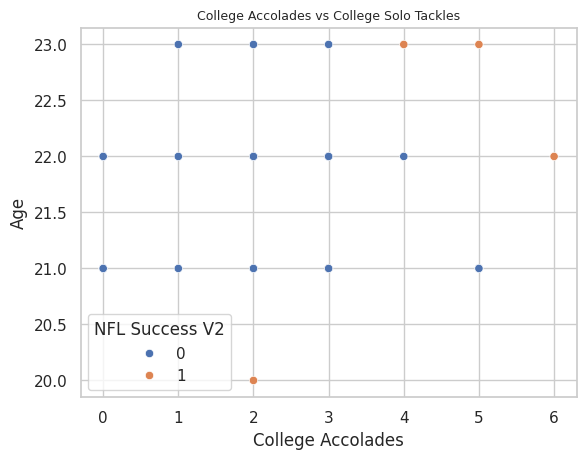

In [ ]:
sns.set(style='whitegrid')
sns.scatterplot(data=linebackers, x='College Accolades', y='Age', hue='NFL Success V2').set_title('College Accolades vs College Solo Tackles', fontsize=9)

###Quarterbacks

In [ ]:
quarterbacks = data[data['Position'] == 'QB']

qb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C', 'Conference'
]

qb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C', 'Conference'
]

quarterbacks = quarterbacks[qb_features]

In [ ]:
qb_conference_dummies = pd.get_dummies(quarterbacks['Conference'])
qb_conference_dummies = qb_conference_dummies.astype(int)
quarterbacks = pd.concat((quarterbacks, qb_conference_dummies), axis=1).drop(['Conference'], axis=1)

In [ ]:
quarterbacks_corr = quarterbacks.corr()['NFL Success V2'].to_frame()
quarterbacks_corr = quarterbacks_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
quarterbacks_corr.style.background_gradient()

In [ ]:
qb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'ACC', 'American', 'Big 12', 'Big Ten', 'MWC', 'Pac-12', 'SEC'
]

qb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Completions_C', 'Passing Attempts_C', 'Completion Pct_C', 'Passing Yards_C', 'Passing Yards per Attempt_C',
    'Adj Passing Yards per Attempt_C', 'Passing Touchdowns_C', 'Interceptions_C', 'Passer Rating_C',
    'ACC', 'American', 'Big 12', 'Big Ten', 'MWC', 'Pac-12', 'SEC'
]


In [ ]:
X = quarterbacks[qb_features_wo_success]
y = quarterbacks['NFL Success V2']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Fit the RandomForestClassifier after ensuring no NaNs are present
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Select the most important features
selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Logistic regression model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_selected, Y_train)

feature_idices = selector.get_support()
for i in range(len(qb_features_wo_success)):
  if feature_idices[i]:
    print(qb_features_wo_success[i])

# Predictions and evaluation
Y_pred = log_reg.predict(X_test_selected)
accuracy = accuracy_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Age
College Accolades
National Championships
Completions_C
Passing Attempts_C
Completion Pct_C
Passing Yards_C
Adj Passing Yards per Attempt_C
Passing Touchdowns_C
Passer Rating_C
Big 12
Accuracy: 0.8
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Wide Receivers

In [ ]:
wide_receivers = data[data['Position'] == 'WR']

wr_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
    'Conference'
]

wr_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
    'Conference'
]

wide_receivers = wide_receivers[wr_features]

In [ ]:
wr_conference_dummies = pd.get_dummies(wide_receivers['Conference'])
wr_conference_dummies = wr_conference_dummies.astype(int)
wide_receivers = pd.concat((wide_receivers, wr_conference_dummies), axis=1).drop(['Conference'], axis=1)

In [ ]:
wide_receivers_corr = wide_receivers.corr()['NFL Success V2'].to_frame()
wide_receivers_corr = wide_receivers_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
wide_receivers_corr.style.background_gradient()

In [ ]:
wr_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
    'ACC', 'American', 'Big 12', 'Big Ten', 'Ind', 'MAC', 'MWC', 'Pac-12', 'SEC'
]

wr_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
    'ACC', 'American', 'Big 12', 'Big Ten', 'Ind', 'MAC', 'MWC', 'Pac-12', 'SEC'
]

In [ ]:
X = wide_receivers[wr_features_wo_success]
y = wide_receivers['NFL Success V2']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
# Fit the RandomForestClassifier after ensuring no NaNs are present
rf = RandomForestClassifier(n_estimators=100, random_state=2)
rf.fit(X_train, Y_train)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Select the most important features
selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Logistic regression model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_selected, Y_train)

feature_idices = selector.get_support()
for i in range(len(wr_features_wo_success)):
  if feature_idices[i]:
    print(wr_features_wo_success[i])

# Predictions and evaluation
Y_pred = log_reg.predict(X_test_selected)
accuracy = accuracy_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_report(Y_test, Y_pred))

College Accolades
Receptions_C
Receiving Yards_C
Receiving Yards per Attempt_C
Receiving TDs_C
Rushing Attempts_C
Rushing Yards_C
SEC
Accuracy: 0.7692307692307693
ROC AUC Score: 0.659090909090909
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.33      0.50      0.40         2

    accuracy                           0.77        13
   macro avg       0.62      0.66      0.63        13
weighted avg       0.81      0.77      0.79        13



###Running Backs

In [ ]:
running_backs = data[data['Position'] == 'RB']

rb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
    'Conference'
]

rb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
    'Conference'
]

running_backs = running_backs[rb_features]

In [ ]:
rb_conference_dummies = pd.get_dummies(running_backs['Conference'])
rb_conference_dummies = rb_conference_dummies.astype(int)
running_backs = pd.concat((running_backs, rb_conference_dummies), axis=1).drop(['Conference'], axis=1)

In [ ]:
running_backs_corr = running_backs.corr()['NFL Success V2'].to_frame()
running_backs_corr = running_backs_corr.drop(['NFL Success V2']).sort_values(by='NFL Success V2', ascending=False)
running_backs_corr.style.background_gradient()

In [ ]:
rb_features = [
    'NFL Success V2', 'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
    'ACC', 'Big 12', 'Big Ten', 'MWC', 'Pac-12', 'SEC'
]

rb_features_wo_success = [
    'Age', 'College Accolades', 'National Championships',
    'Receptions_C', 'Receiving Yards_C', 'Receiving Yards per Attempt_C', 'Receiving TDs_C',
    'Rushing Attempts_C', 'Rushing Yards_C' , 'Rushing Yards per Attempt_C', 'Rushing Touchdowns_C',
    'ACC', 'Big 12', 'Big Ten', 'MWC', 'Pac-12', 'SEC'
]

In [ ]:
X = running_backs[rb_features_wo_success]
y = running_backs['NFL Success V2']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [ ]:
# Fit the RandomForestClassifier after ensuring no NaNs are present
rf = RandomForestClassifier(n_estimators=100, random_state=2)
rf.fit(X_train, Y_train)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Select the most important features
selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Logistic regression model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_selected, Y_train)

feature_idices = selector.get_support()
for i in range(len(rb_features_wo_success)):
  if feature_idices[i]:
    print(rb_features_wo_success[i])

# Predictions and evaluation
Y_pred = log_reg.predict(X_test_selected)
accuracy = accuracy_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_report(Y_test, Y_pred))

College Accolades
Receptions_C
Receiving Yards_C
Receiving Yards per Attempt_C
Receiving TDs_C
Rushing Attempts_C
Rushing Yards_C
Rushing Yards per Attempt_C
Rushing Touchdowns_C
Accuracy: 0.75
ROC AUC Score: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.50      0.50      0.50         2

    accuracy                           0.75         8
   macro avg       0.67      0.67      0.67         8
weighted avg       0.75      0.75      0.75         8

